## Постановка задачи:

- Парсинг данных с сайта cian.ru, а именно характеристик квартир
- Предобработка данных
- Построение регрессионной модели для прогнозирования стоимости недвижимости
- Оценка модели с помощью метрик R2, MAE

In [1]:
from bs4 import BeautifulSoup

import requests
import pandas as pd
import re
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Парсинг

Открываю заранее заготовленный файл со списком URL для парсинга

In [ ]:
urls = []

with open('urls.csv') as f:
    for url in f:
        urls.append(url.strip())

Скрипт для парсинга страницы, пример страницы https://www.cian.ru/sale/flat/228290773/

In [ ]:
all_houses = {}

with open('urls.csv') as urls:
    for url in urls:
        about_house = {}
        metro = {}
        h = {'User-agent': 'Googlebot'}
        r = requests.get(url, headers=h)
        if r.ok:
            p = BeautifulSoup(r.text, 'lxml')

            #Получаю количество комнат
            heading_1 = re.match(r"\d*", p.h1.text)
            if not heading_1.group(0):
                about_house['Количество комнат'] = 1
            else:
                about_house['Количество комнат'] = heading_1.group(0)

            #Получаю адрес через API сервиса Яндекса Геокодер
            address = p.address.text.replace('На карте', '')
            url_api = 'https://geocode-maps.yandex.ru/1.x/'
            params = {
                    'apikey': '2a692863-e05b-45c0-8c2d-34ef5f3fc32c', 
                    'format': 'json',
                    'geocode': address
                    }
            request_to_api = requests.get(url_api, params=params)
            about_house['Долгота'], about_house['Широта'] = json.loads(request_to_api.text)['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point'].get('pos').split(' ')

            #Вытаскиваю информацию о жк
            for i in p.findAll('div', class_='a10a3f92e9--item--2Ig2y'):
                q = list(i.children)
                about_house[q[0].text] = q[1].text

            #Вытаскиваю цену
            about_house['Цена'] = p.find('span', class_='a10a3f92e9--price_value--1iPpd').span.attrs['content'][:-2].replace(' ', '')

            #Вытаскиваю общую информацию
            for i in p.findAll('li', class_='a10a3f92e9--item--_ipjK'):
                chars = list(i)
                about_house[chars[0].text] = chars[1].text

            #Сводная информация под фотками
            for i in p.findAll('div', class_='a10a3f92e9--info--3XiXi'):
                chars = list(i)
                #Делю этажи на две составляющих
                if chars[1].text == 'Этаж':
                    floor, all_floor = chars[0].text.split(' из ')
                    about_house['Этаж'], about_house['Всего этажей'] = floor, all_floor
                elif chars[1].text == 'Срок сдачи':
                    #Если есть в дате сдачи номер квартала, то делю дату на две составляющих
                    if 'кв.' in chars[0].text:
                        kvartal, year = chars[0].text.split(' кв. ')
                        about_house['Квартал сдачи'], about_house['Год сдачи'] = kvartal, year
                    else:
                        year = chars[0].text
                        about_house['Год сдачи'] = year
                else:
                    about_house[chars[1].text] = chars[0].string.replace('\xa0', '')
                            
            #Разбираюсь с метро
            for elem in p.findAll('li', class_='a10a3f92e9--underground--kONgx'):
                #Если где-то нет времени до метро, то ставлю None
                if elem.span:
                    metro[elem.a.text] = elem.span.text.replace(' ⋅  ', '')
                elif not elem.span:
                    metro[elem.a.text] = None
                #Прохожусь по каждому метро и создаю отдельный элемент метро №
                for i, name_time in enumerate(metro.items(), 1):
                    name, time_to_station = 'Метро ' + str(i), 'Время до метро ' + str(i)
                    about_house[name], about_house[time_to_station] = name_time[0], name_time[1]
            #Создаю в словаре all_houses элемент с key = url, и value = словарю about_house со всеми признаками
            all_houses[url] = about_house
        else:
            print('Ошибка. Статус {}'.format(r.status_code))

Создаю DataFrame и импортирую в csv для дальнейшего использования:

In [ ]:
df_house = pd.DataFrame(data=all_houses).T
df_house.to_csv('df_house.csv', encoding='utf-8', sep=';')

## Обработка данных

Считываю ранее сохраненный файл в переменную df_house:

In [842]:
df_house = pd.read_csv('df_house.csv', encoding='utf-8', sep=';')

In [843]:
df_house.isnull().sum()

Unnamed: 0                                                                         0
Количество комнат                                                                  0
Долгота                                                                            0
Широта                                                                             0
Лифты                                                                           1306
Парковка                                                                        4706
Цена                                                                               0
Тип жилья                                                                       1131
Высота потолков                                                                 4411
Санузел                                                                         2252
Ремонт                                                                          3427
Вид из окон                                                      

Сбрасываю колонки, которые в последствие не будут использованы, либо те, в которых много пропусков:

In [844]:
columns_for_drop = ['Вид из окон', 'Метро 3', 'Парковка', 'Тип перекрытий', 
                    'Время до метро 3', 'Время до метро 2', 'Время до метро 1', 
                    'Площадь комнат+ обозначение смежных комнат- обозначение изолированных комнат', 
                    'Отделка', 'Квартал сдачи', 'Аварийность', 'Планировка', 'Газоснабжение', 'Строительная серия', 
                    'Всего комнат в квартире', 'Комнат в продажу', 'Площадь комнаты', 'Комната', 'Размер доли']
df_house = df_house.drop(columns=columns_for_drop)

Следующее количество пустых значений придется обработать, заменить или удалить:

In [845]:
df_house.isnull().sum()

Unnamed: 0              0
Количество комнат       0
Долгота                 0
Широта                  0
Лифты                1306
Цена                    0
Тип жилья            1131
Высота потолков      4411
Санузел              2252
Ремонт               3427
Общая                 127
Этаж                    0
Всего этажей            0
Построен             4084
Метро 1               184
Метро 2              1803
Балкон/лоджия        4512
Жилая                2132
Кухня                2059
Год сдачи            6543
Тип дома             3203
Год постройки        3878
Подъезды             4149
Отопление            4333
Мусоропровод         5609
dtype: int64

Смысл кода ниже заключается в том, что дома, которые расположены по одним и тем же координатам, вероятнее всего обладают одинаковыми признаками, поэтому там где в признаках стоят null-ы, их можно заменить на известные значения. Фичи для замены указаны в переменной cols_to_fill.

In [846]:
koord = ['Долгота','Широта']
q = df_house[df[koord].duplicated(keep=False)]

def fill_nans(q, col1, col2):
    dict_for_nans = {}
    d = set(q[col1].values)
    for elem in d:
        s = list(q[(q[col1] == elem) & (~q[col2].isnull())][col2].values)
        if len(s)==1:
            dict_for_nans[elem] = list(set(q[(q[col1] == elem) & (~q[col2].isnull())][col2].values))[0]
    return dict_for_nans    

def fill_nans_for_h(q, col1, col2):
    dict_for_nans = {}
    d = set(q[col1].values)
    for elem in d:
        s = set(q[(q[col1] == elem) & (~q[col2].isnull())][col2].values)
        if s:
            s = list(map(lambda x: re.search(r'\d?\.*\d?', x.replace(',', '.').replace('<', '')).group(0), s))
            dict_for_nans[elem] = str(np.median(list(map(float, s))))
    return dict_for_nans 

cols_to_fill = ['Метро 1', 'Метро 2', 'Тип жилья', 'Высота потолков', 
                'Построен', 'Год сдачи', 'Балкон/лоджия', 'Санузел', 'Ремонт', 
                'Тип дома', 'Год постройки', 'Отопление', 'Жилая', 'Кухня', 
                'Общая', 'Мусоропровод', 'Подъезды']

for col in cols_to_fill:
    if col in ['Высота потолков', 'Общая', 'Жилая', 'Кухня']:
        f = fill_nans_for_h(q, 'Долгота', col) 
    else:    
        f = fill_nans(q, 'Долгота', col)
    series_f = pd.DataFrame(data=pd.Series(f)).reset_index().rename(columns={'index': 'Долгота', 0: col})
    df_house[col].fillna(series_f[col], inplace=True)

Делю df_house на train и test, чтобы избежать data-likage при заменах.

In [960]:
from sklearn.model_selection import train_test_split

X = np.array(df_house[[i for i in df.columns if i != 'Цена']])
y = np.array(df_house['Цена'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

sorted_columns = [col for col in df_house.columns if col != 'Цена'] + list(['Цена'])

df_train = pd.DataFrame(data=np.c_[X_train, y_train], columns=sorted_columns)
df_test = pd.DataFrame(data=np.c_[X_test, y_test], columns=sorted_columns)

In [961]:
df_train['Цена'] = df_train['Цена'].astype('float')
df_test['Цена'] = df_test['Цена'].astype('float')

In [962]:
df_train

,Unnamed: 0,Количество комнат,Долгота,Широта,Лифты,Тип жилья,Высота потолков,Санузел,Ремонт,Общая,...,Балкон/лоджия,Жилая,Кухня,Год сдачи,Тип дома,Год постройки,Подъезды,Отопление,Мусоропровод,Цена
0,https://www.cian.ru/sale/flat/237132957/,1,37.7423,55.8109,"1 пасс., 1 груз.",Новостройка,"2,9 м",1 совмещенный,NaN,"39,09м²",...,1 лоджия,"16,4м²","9,5м²",NaN,NaN,NaN,NaN,NaN,NaN,10001567.0
1,https://www.cian.ru/sale/flat/237601348/,5,37.5974,55.6508,NaN,NaN,NaN,NaN,NaN,132м²,...,NaN,107м²,20м²,NaN,NaN,NaN,NaN,NaN,NaN,30000000.0
2,https://www.cian.ru/sale/flat/237463066/,1,37.7598,55.8275,Нет,Вторичка,"2,64 м",1 совмещенный,Без ремонта,"30,3м²",...,1 балкон,"19,1м²","5,3м²",NaN,Панельный,1964,6,Центральное,NaN,6200000.0
3,https://www.cian.ru/sale/flat/235812506/,2,37.5994,55.5934,"1 пасс., 1 груз.",Вторичка,"2,64 м",1 совмещенный,Косметический,44м²,...,1 лоджия,NaN,10м²,NaN,Монолитный,2012,1,Центральное,NaN,9700000.0
4,https://www.cian.ru/sale/flat/199879487/,2,37.3953,55.8169,"1 пасс., 1 груз.",Вторичка,"2,64 м",1 совмещенный,Евроремонт,54м²,...,1 балкон,30м²,9м²,NaN,NaN,1983,8,Центральное,Есть,11500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6357,https://www.cian.ru/sale/flat/235160827/,2,37.329,55.5505,Нет,Вторичка,NaN,1 раздельный,Косметический,"50,6м²",...,1 лоджия,25м²,12м²,NaN,Монолитный,2013,3,Котел/Квартирное отопление,NaN,6900000.0
6358,https://www.cian.ru/sale/flat/236544793/,3,37.693,55.7482,"1 пасс., 1 груз.",Вторичка,"3,2 м",1 раздельный,Без ремонта,"70,9м²",...,1 лоджия,"38,8м²","22,6м²",NaN,NaN,NaN,NaN,NaN,NaN,17400000.0
6359,https://www.cian.ru/sale/flat/215477363/,2,37.4258,55.7374,"1 пасс., 1 груз.",Вторичка,NaN,1 раздельный,Косметический,"59,7м²",...,"1 балкон, 1 лоджия","30,9м²",10м²,NaN,NaN,NaN,NaN,NaN,NaN,15100000.0
6360,https://www.cian.ru/sale/flat/226504586/,1,37.7053,55.6457,"1 пасс., 1 груз.",Новостройка,2.4,1 совмещенный,NaN,"25,5м²",...,1 балкон,15м²,5м²,2021,Монолитный,NaN,NaN,NaN,NaN,5600000.0


Объединяю три колонки <b>'Год постройки', 'Год сдачи', 'Построен'</b> в одну, так как по сути это одно и тоже:

In [963]:
df_train['Год'] = df_train['Год постройки'].fillna(df_train['Год сдачи']).fillna(df_train['Построен'])
df_train = df_train.drop(columns=['Год постройки', 'Год сдачи', 'Построен'])

df_test['Год'] = df_test['Год постройки'].fillna(df_test['Год сдачи']).fillna(df_test['Построен'])
df_test = df_test.drop(columns=['Год постройки', 'Год сдачи', 'Построен'])

Посмотрим на распределение (замены null-ов будет ниже):

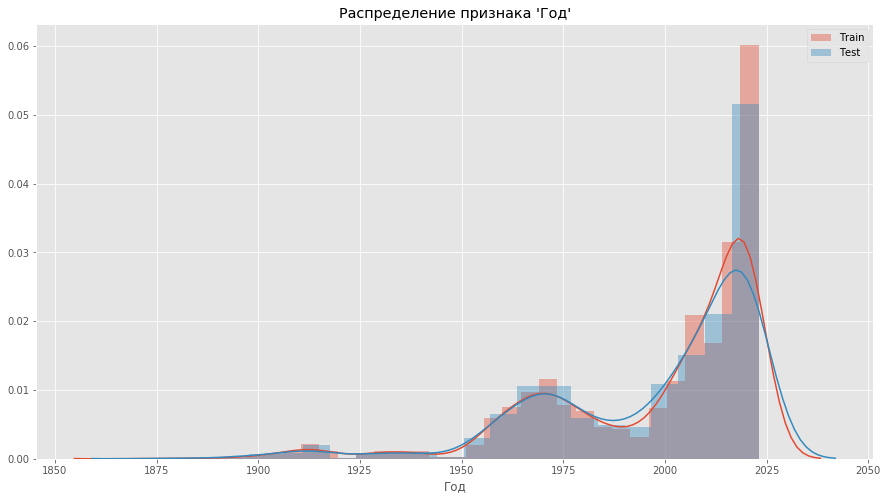

In [964]:
plt.figure(figsize=(15,8))

sns.distplot(df_train.loc[~df_train.Год.isnull()]['Год'], label='Train')
sns.distplot(df_test.loc[~df_test.Год.isnull()]['Год'], label='Test')

plt.title("Распределение признака 'Год'")
plt.legend()
plt.show()

Площадь представляю типом Float:

In [965]:
df_train['Жилая']

0       16,4м²
1        107м²
2       19,1м²
3          NaN
4         30м²
         ...  
6357      25м²
6358    38,8м²
6359    30,9м²
6360      15м²
6361      19м²
Name: Жилая, Length: 6362, dtype: object

In [966]:
re_for_square = lambda x: re.match(r'(\d+[,.]?\d?)', x).group(0).replace(',', '.')

for col in ['Жилая', 'Кухня', 'Общая']:
    df_train[col] = df_train.loc[~df_train[col].isnull()][col].map(re_for_square).astype('float')
    df_test[col] = df_test.loc[~df_test[col].isnull()][col].map(re_for_square).astype('float')

Посмотрим на их распределение:

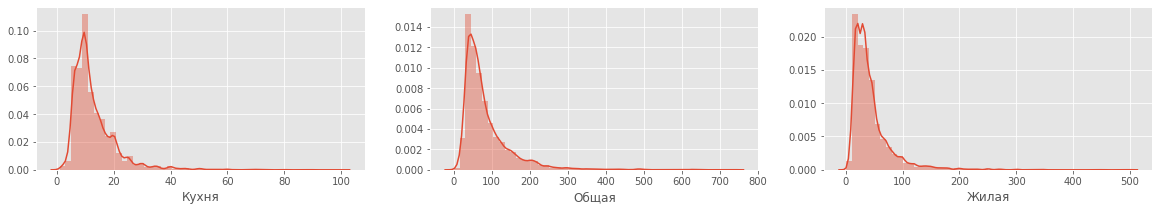

In [967]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20, 3)

sns.distplot(df_train.loc[~df_train.Кухня.isnull()]['Кухня'], ax=axes[0])
sns.distplot(df_train.loc[~df_train.Общая.isnull()]['Общая'], ax=axes[1])
sns.distplot(df_train.loc[~df_train.Жилая.isnull()]['Жилая'], ax=axes[2])

plt.show()

Сделаем замены null-ов на медиану из df_train:

In [968]:
for col in ['Жилая', 'Общая', 'Кухня']:
    df_train.loc[df_train[(df_train[col].isnull()) | (df_train[col] == 0) | (df_train[col] == 1)].index, col] \
    = df_train[col].median()
    df_test.loc[df_test[(df_test[col].isnull()) | (df_test[col] == 0) | (df_test[col] == 1)].index, col] \
    = df_train[col].median() 

Посмотрим на распределение еще раз (+- норм):

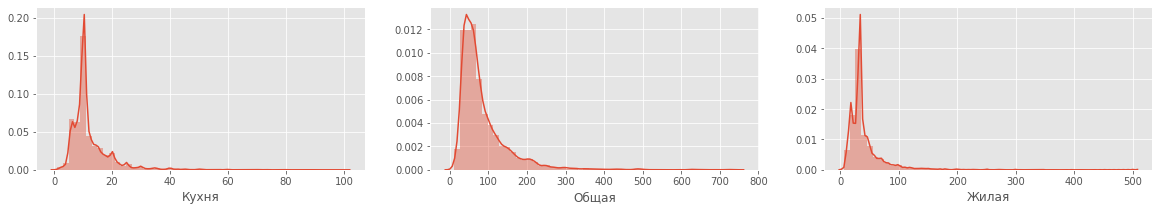

In [969]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20,3)

sns.distplot(df_train['Кухня'], ax=axes[0])
sns.distplot(df_train['Общая'], ax=axes[1])
sns.distplot(df_train['Жилая'], ax=axes[2])

plt.show()

Вырежем числа и сделаем похожую замену только для <b>высоты потолков:</b>

In [970]:
df_train['Высота потолков']

0        2,9 м
1          NaN
2       2,64 м
3       2,64 м
4       2,64 м
         ...  
6357       NaN
6358     3,2 м
6359       NaN
6360       2.4
6361       NaN
Name: Высота потолков, Length: 6362, dtype: object

In [971]:
re_for_height = lambda x: re.match(r'(\d+[,.]?\d*)', x).group(0).replace(',','.')

df_train['Высота потолков'] = df_train.loc[~df_train['Высота потолков'].isnull()]['Высота потолков'].map(re_for_height).astype('float')
df_test['Высота потолков'] = df_test.loc[~df_test['Высота потолков'].isnull()]['Высота потолков'].map(re_for_height).astype('float')

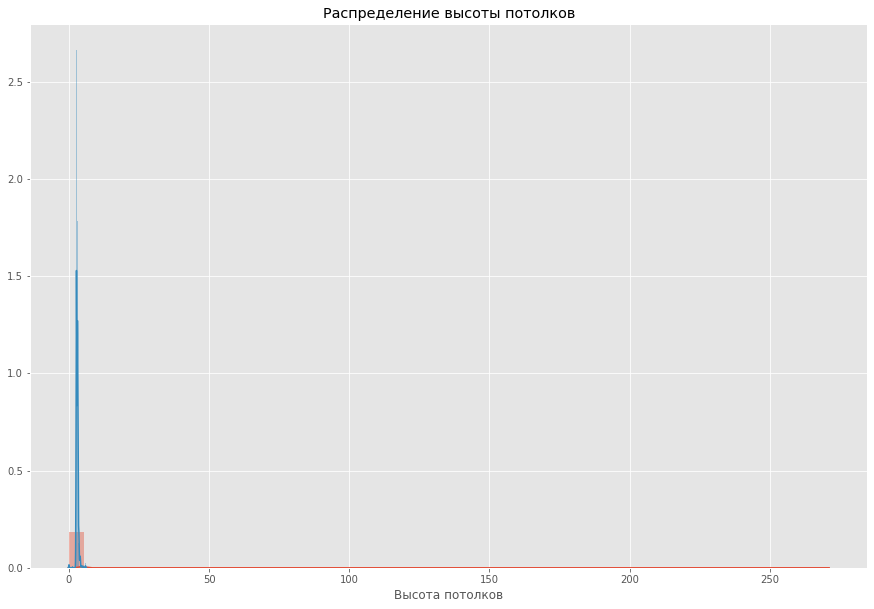

In [972]:
plt.figure(figsize=(15,10))

sns.distplot(df_train[~df_train['Высота потолков'].isnull()]['Высота потолков'])
sns.distplot(df_test[~df_test['Высота потолков'].isnull()]['Высота потолков'])

plt.title('Распределение высоты потолков')

plt.show()

Заменим выбросы, нулевые значения и null-ы на медиану:

In [973]:
df_train['Высота потолков'].describe()

count    3458.000000
mean        3.046110
std         4.641854
min         0.000000
25%         2.640000
50%         2.950000
75%         3.100000
max       271.000000
Name: Высота потолков, dtype: float64

In [974]:
df_test['Высота потолков'].describe()

count    1139.000000
mean        2.930105
std         0.406232
min         0.000000
25%         2.640000
50%         2.950000
75%         3.100000
max         5.900000
Name: Высота потолков, dtype: float64

In [975]:
df_train.loc[df_train[(df_train['Высота потолков'].isnull()) | (df_train['Высота потолков'] == 0) 
                    | (df_train['Высота потолков'] > 20)].index, 'Высота потолков'] = df_train['Высота потолков'].median()
df_test.loc[df_test[(df_test['Высота потолков'].isnull()) | (df_test['Высота потолков'] == 0) 
                    | (df_test['Высота потолков'] > 20)].index, 'Высота потолков'] = df_train['Высота потолков'].median()

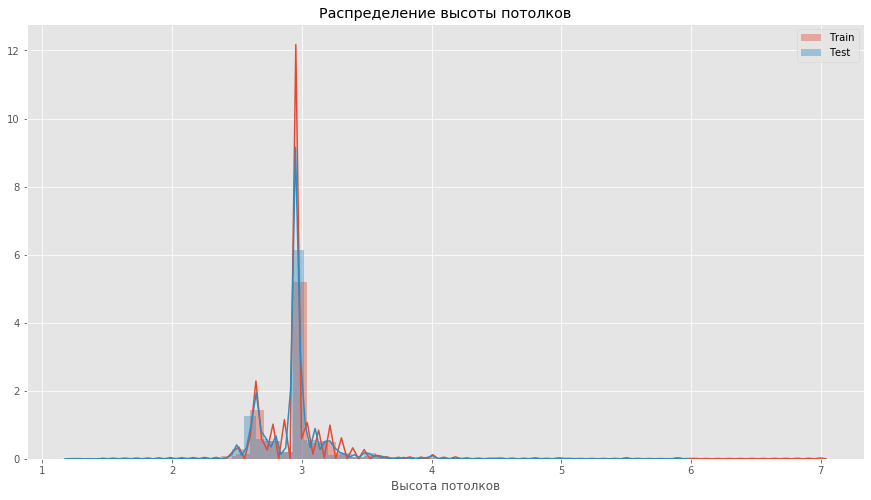

In [976]:
plt.figure(figsize=(15,8))

sns.distplot(df_train['Высота потолков'], label='Train')
sns.distplot(df_test['Высота потолков'], label='Test')

plt.title('Распределение высоты потолков')
plt.legend()

plt.show()

<b>Балкон/Лоджия</b>. Заменим nan на 0 балконов. Вырежем все числа из балконов и просуммируем их.

In [977]:
df_test['Балкон/лоджия'].unique()

array(['1 балкон, 1 лоджия', nan, '1 балкон', '1 лоджия',
       '2 балкона, 1 лоджия', '2 лоджии', '2 балкона', '3 балкона',
       '4 балкона', '4 лоджии', '3 лоджии', '1 балкон, 2 лоджии',
       '2 балкона, 2 лоджии', '3 балкона, 1 лоджия',
       '4 балкона, 4 лоджии', '3 балкона, 3 лоджии'], dtype=object)

In [978]:
df_train['Балкон/лоджия'] = df_train['Балкон/лоджия'].fillna('0 балконов')
df_test['Балкон/лоджия'] = df_test['Балкон/лоджия'].fillna('0 балконов')

balcony_f = lambda x: sum(list(map(int, re.findall(r'\d', x))))

balcony = []

for elem in df_train['Балкон/лоджия']:
    balcony.append(balcony_f(elem))
    
df_train = df_train.assign(Балкон=balcony)
df_train = df_train.drop(columns=['Балкон/лоджия', 'Unnamed: 0']).reset_index().drop(columns=['index'])

balcony = []

for elem in df_test['Балкон/лоджия']:
    balcony.append(balcony_f(elem))
    
df_test = df_test.assign(Балкон=balcony)
df_test = df_test.drop(columns=['Балкон/лоджия', 'Unnamed: 0']).reset_index().drop(columns=['index'])

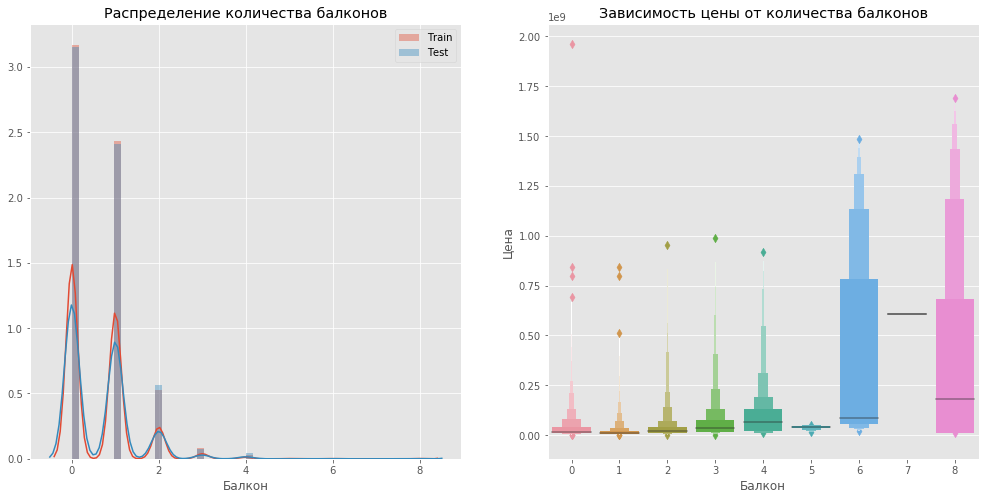

In [979]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))

sns.distplot(df_train.Балкон, label='Train', ax=axes[0])
sns.distplot(df_test.Балкон, label='Test', ax=axes[0])
sns.boxenplot(x=df_train['Балкон'], y=df_train['Цена'], ax=axes[1])

axes[0].set_title('Распределение количества балконов')
axes[1].set_title('Зависимость цены от количества балконов')
axes[0].legend()

plt.show()

Количество балконов лучше разбить на три группы: 0 балконов, 1 балкон, больше или равно 2 балконов:

In [980]:
df_train['Балкон'] = df_train['Балкон'].map({0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2})
df_test['Балкон'] = df_test['Балкон'].map({0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2})

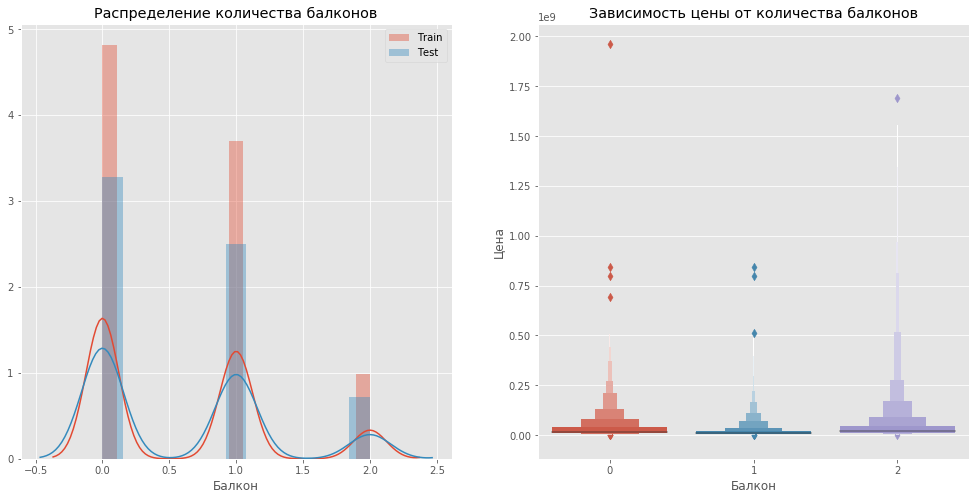

In [981]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))

sns.distplot(df_train.Балкон, label='Train', ax=axes[0])
sns.distplot(df_test.Балкон, label='Test', ax=axes[0])
sns.boxenplot(x=df_train['Балкон'], y=df_train['Цена'], ax=axes[1])

axes[0].set_title('Распределение количества балконов')
axes[1].set_title('Зависимость цены от количества балконов')
axes[0].legend()

plt.show()

<b>Мусоропровод.</b> Заменим nan в мусоропроводе на нет:

In [982]:
df_train['Мусоропровод'].unique()

array([nan, 'Есть', 'Нет'], dtype=object)

In [983]:
df_train['Мусоропровод'] = df_train['Мусоропровод'].fillna('Нет')
df_test['Мусоропровод'] = df_test['Мусоропровод'].fillna('Нет')

musor = {'Есть': 1, 'Нет': 0}

df_train['Мусоропровод'] = df_train['Мусоропровод'].map(musor)
df_test['Мусоропровод'] = df_test['Мусоропровод'].map(musor)

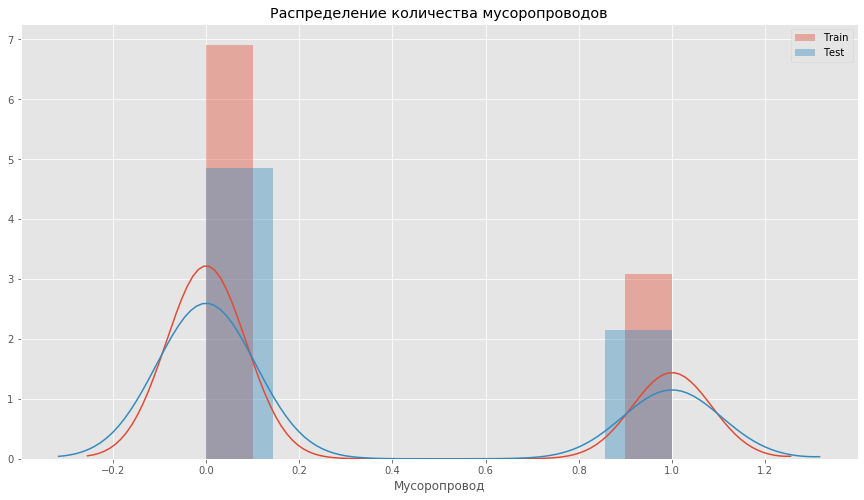

In [984]:
plt.figure(figsize=(15,8))

sns.distplot(df_train.Мусоропровод, label='Train')
sns.distplot(df_test.Мусоропровод, label='Test')

plt.title('Распределение количества мусоропроводов')
plt.legend()

plt.show()

<b>Санузлы.</b> Вырезаю цифры из количества санузлов, суммирую их и применяю map для изменения текущих значений:

In [985]:
df_train['Санузел'].unique()

array(['1 совмещенный', nan, '1 раздельный', '2 совмещенных',
       '3 совмещенных', '3 раздельных', '2 совмещенных, 1 раздельный',
       '2 совмещенных, 2 раздельных', '4 совмещенных',
       '3 совмещенных, 1 раздельный', '4 раздельных', '2 раздельных',
       '1 совмещенный, 1 раздельный', '1 совмещенный, 2 раздельных',
       '3 совмещенных, 3 раздельных', '4 совмещенных, 2 раздельных',
       '4 совмещенных, 3 раздельных', '4 совмещенных, 4 раздельных',
       '3 совмещенных, 4 раздельных', '3 совмещенных, 2 раздельных',
       '2 совмещенных, 3 раздельных', '4 совмещенных, 1 раздельный',
       '1 совмещенный, 3 раздельных', '2 совмещенных, 4 раздельных'],
      dtype=object)

In [986]:
bath_f = lambda x: sum(list(map(int, re.findall(r'\d',  x))))

df_train['Санузел'] = df_train.loc[~df_train['Санузел'].isnull()]['Санузел'].map(bath_f)
df_test['Санузел'] = df_test.loc[~df_test['Санузел'].isnull()]['Санузел'].map(bath_f)

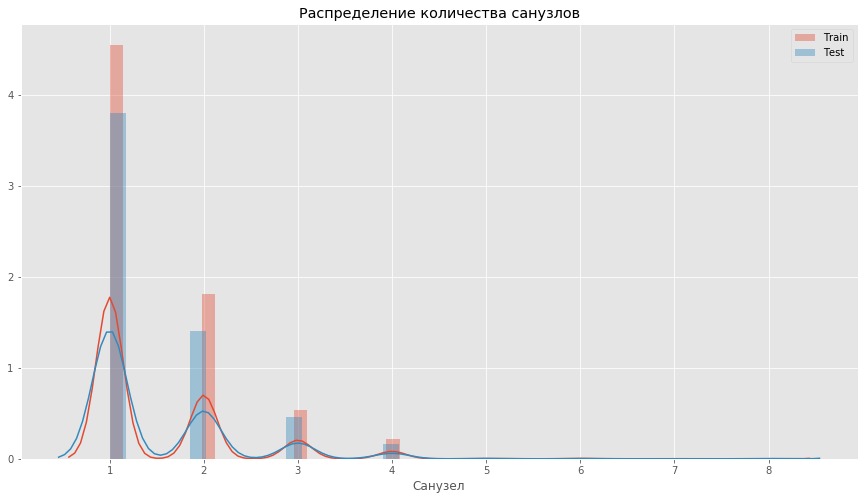

In [987]:
plt.figure(figsize=(15,8))

sns.distplot(df_train[~df_train.Санузел.isnull()]['Санузел'], label='Train')
sns.distplot(df_test[~df_test.Санузел.isnull()]['Санузел'], label='Test')

plt.title('Распределение количества санузлов')
plt.legend()

plt.show()

Теперь позаменяем null, посмотрим где и сколько их:

In [988]:
df_train.isnull().sum()

Количество комнат       0
Долгота                 0
Широта                  0
Лифты                 944
Тип жилья             776
Высота потолков         0
Санузел              1567
Ремонт               2435
Общая                   0
Этаж                    0
Всего этажей            0
Метро 1               139
Метро 2              1302
Жилая                   0
Кухня                   0
Тип дома             2312
Подъезды             3032
Отопление            3174
Мусоропровод            0
Цена                    0
Год                   624
Балкон                  0
dtype: int64

In [989]:
df_test.isnull().sum()

Количество комнат       0
Долгота                 0
Широта                  0
Лифты                 362
Тип жилья             294
Высота потолков         0
Санузел               566
Ремонт                851
Общая                   0
Этаж                    0
Всего этажей            0
Метро 1                42
Метро 2               464
Жилая                   0
Кухня                   0
Тип дома              789
Подъезды             1028
Отопление            1074
Мусоропровод            0
Цена                    0
Год                   218
Балкон                  0
dtype: int64

Заменяю пропущенные <b>санузлы</b> на медиану:

In [990]:
df_train['Санузел'].median()

1.0

In [991]:
df_train['Санузел'] = df_train['Санузел'].fillna(value=df_train['Санузел'].median())
df_test['Санузел'] = df_test['Санузел'].fillna(value=df_train['Санузел'].median())

Создадим на основе этого признака бинарный признак <b>>= 2 санузлов</b>:

In [992]:
pd.merge(df_train.groupby('Санузел')['Общая'].count(), df_test.groupby('Санузел')['Общая'].count(), how='left', on='Санузел')

,Общая_x,Общая_y
Санузел,,
1.0,4625,1575
2.0,1217,373
3.0,359,122
4.0,144,43
5.0,5,3
6.0,8,2
7.0,2,1
8.0,2,2


Видим, что в принципе есть тенденция на увеличение цены квартиры при росте количества санузлов, возможно хороший признак:

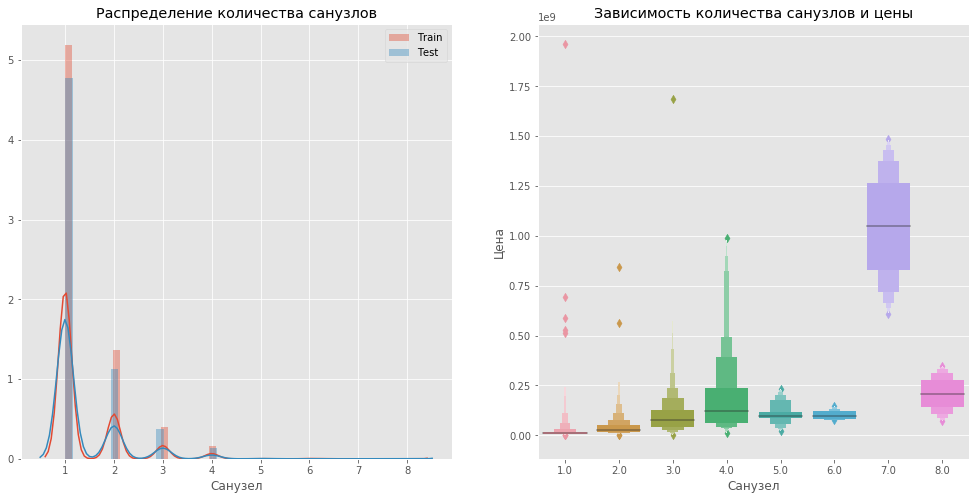

In [993]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))

sns.distplot(df_train['Санузел'], label='Train', ax=axes[0])
sns.distplot(df_test['Санузел'], label='Test', ax=axes[0])
sns.boxenplot(x='Санузел', y='Цена', data=df_train, ax=axes[1])

axes[0].set_title('Распределение количества санузлов')
axes[0].legend()
axes[1].set_title('Зависимость количества санузлов и цены')

plt.show()

Создадим бинарный признак (Санузлов >= 2) на основе санузлов:

In [994]:
dict_for_toil = {num:(0 if num < 2 else 1) for num in set(df_train['Санузел'].values)}

df_train['Санузлов >= 2'] = df_train['Санузел'].map(dict_for_toil)
df_test['Санузлов >= 2'] = df_test['Санузел'].map(dict_for_toil)

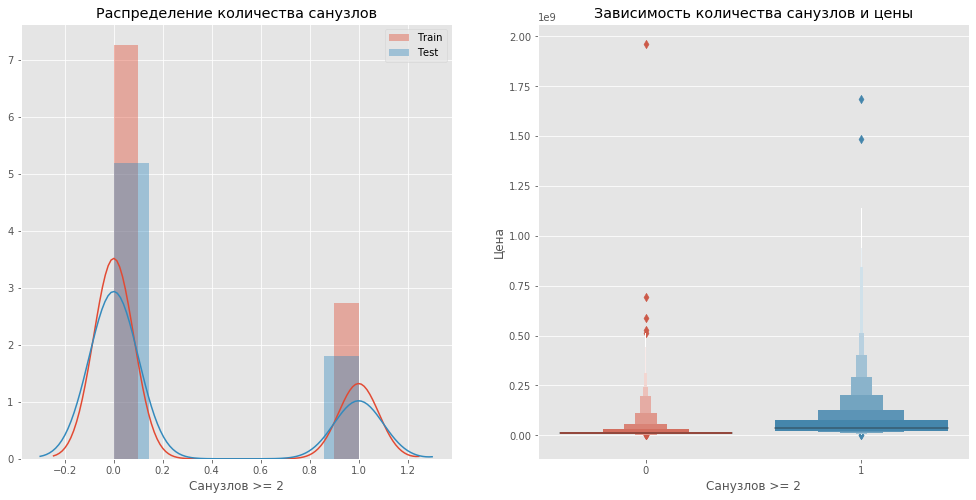

In [995]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))

sns.distplot(df_train['Санузлов >= 2'], label='Train', ax=axes[0])
sns.distplot(df_test['Санузлов >= 2'], label='Test', ax=axes[0])
sns.boxenplot(x='Санузлов >= 2', y='Цена', data=df_train, ax=axes[1])

axes[0].set_title('Распределение количества санузлов')
axes[0].legend()
axes[1].set_title('Зависимость количества санузлов и цены')

plt.show()

<b>Лифты</b>:

- Заменяю nan на "пусто". 
- Вырезаю цифры и суммирую. 
- Там где "нет" - 0, там где "есть" - 1, там где 'пусто' замена с помощью np.where. 
- Сам признак превратим в бинарный из-за значений разного типа - есть и числовые, есть и бинарные (есть, нет).

Сами значения:

In [996]:
set(df_train['Лифты'].unique()) | set(df_test['Лифты'].unique())

{'1 пасс., 1 груз.',
 '1 пасс., 2 груз.',
 '1 пасс., 3 груз.',
 '1 пасс., 4 груз.',
 '10 всего',
 '11 всего',
 '12 всего',
 '13 всего',
 '14 всего',
 '15 всего',
 '16 всего',
 '17 всего',
 '18 всего',
 '18 пасс.',
 '19 всего',
 '2 всего',
 '2 груз.',
 '2 пасс.',
 '2 пасс., 1 груз.',
 '2 пасс., 2 груз.',
 '2 пасс., 3 груз.',
 '2 пасс., 4 груз.',
 '2 пасс., 6 груз.',
 '20 всего',
 '21 всего',
 '22 всего',
 '23 всего',
 '24 всего',
 '26 всего',
 '27 всего',
 '28 всего',
 '29 всего',
 '3 всего',
 '3 груз.',
 '3 пасс.',
 '3 пасс., 1 груз.',
 '3 пасс., 2 груз.',
 '3 пасс., 3 груз.',
 '30 всего',
 '36 всего',
 '4 всего',
 '4 груз.',
 '4 пасс.',
 '4 пасс., 1 груз.',
 '4 пасс., 2 груз.',
 '4 пасс., 4 груз.',
 '42 всего',
 '43 всего',
 '5 всего',
 '5 пасс., 1 груз.',
 '5 пасс., 2 груз.',
 '50 пасс.',
 '6 всего',
 '6 пасс.',
 '60 пасс.',
 '7 всего',
 '7 пасс.',
 '8 всего',
 '8 пасс.',
 '9 всего',
 nan,
 'Есть',
 'Есть грузовой',
 'Нет'}

In [997]:
df_train.groupby('Лифты')['Общая'].count()

Лифты
1 пасс., 1 груз.    1586
1 пасс., 2 груз.      87
1 пасс., 3 груз.      19
1 пасс., 4 груз.      17
10 всего              25
11 всего               4
12 всего              11
13 всего               6
14 всего              12
15 всего              14
16 всего              10
17 всего               2
18 всего               3
18 пасс.               1
19 всего               5
2 всего               37
2 груз.               22
2 пасс.              385
2 пасс., 1 груз.     300
2 пасс., 2 груз.     201
2 пасс., 3 груз.      13
2 пасс., 4 груз.       9
2 пасс., 6 груз.       1
20 всего               8
21 всего               4
22 всего              10
23 всего               1
24 всего              20
26 всего               2
27 всего              12
28 всего               1
29 всего               3
3 всего               24
3 груз.                2
3 пасс.               56
3 пасс., 1 груз.      46
3 пасс., 2 груз.       6
3 пасс., 3 груз.      14
4 всего               39
4 груз.            

In [998]:
df_train['Лифты'] = df_train['Лифты'].fillna(value='Пусто')
df_test['Лифты'] = df_test['Лифты'].fillna(value='Пусто')

dict_for_lift = {num:(0 if num == 'Нет' else 1) for num in (set(df_train['Лифты'].values) | set(df_test['Лифты'].values))}

df_train['Есть лифт'] = df_train['Лифты'].map(dict_for_lift)
df_test['Есть лифт'] = df_test['Лифты'].map(dict_for_lift)

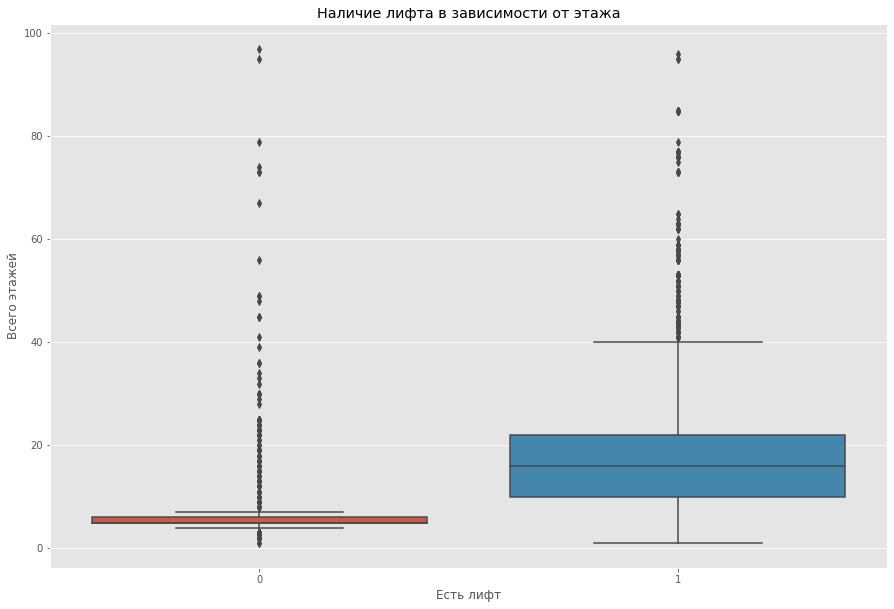

In [999]:
plt.figure(figsize=(15,10))
sns.boxplot(x=df_train['Есть лифт'], y=df_train['Всего этажей'])
plt.title('Наличие лифта в зависимости от этажа')
plt.show()

Заменяю лифты со значением "пусто" (там где был пропуск) на значения по условию: <b>там где <= 5 этажей в доме - лифта нет, иначе - есть.</b>

In [1000]:
df_train['Всего этажей'] = df_train['Всего этажей'].astype('int64')
df_test['Всего этажей'] = df_test['Всего этажей'].astype('int64')

In [1001]:
df_train.groupby('Есть лифт')['Всего этажей'].median()

Есть лифт
0     5
1    16
Name: Всего этажей, dtype: int64

In [1002]:
df_train.loc[df_train[(df_train['Лифты']=='Пусто')].index, 'Есть лифт'] = np.where(df_train[(df_train['Лифты']=='Пусто')]['Всего этажей'] < 6, 0, 1)
df_test.loc[df_test[(df_test['Лифты']=='Пусто')].index, 'Есть лифт'] = np.where(df_test[(df_test['Лифты']=='Пусто')]['Всего этажей'] < 6, 0, 1)

In [1003]:
df_train = df_train.drop(['Лифты'], axis=1)
df_test = df_test.drop(['Лифты'], axis=1)

Разделяю тип жилья на два признака - <b>"Вторичка" (Вторичка/Новостройка)</b> и <b>"Тип квартиры" (Обычная/Апартаменты/Пентхаус)</b>:

In [1004]:
set(df_train['Тип жилья'].values)

{nan,
 'Вторичка',
 'Вторичка Апартаменты',
 'Вторичка Пентхаус',
 'Новостройка',
 'Новостройка Апартаменты',
 'Новостройка Пентхаус'}

In [1005]:
df_type_train = df_train['Тип жилья'].str.split(expand=True)
df_type_train[1].fillna('Обычная', inplace=True)
df_train = pd.concat([df_train, df_type_train], axis=1)
df_train.rename(columns={0: 'Вторичка', 1: 'Тип квартиры'}, inplace=True)
df_train = df_train.drop(['Тип жилья'], axis=1)

df_type_test = df_test['Тип жилья'].str.split(expand=True)
df_type_test[1].fillna('Обычная', inplace=True)
df_test = pd.concat([df_test, df_type_test], axis=1)
df_test.rename(columns={0: 'Вторичка', 1: 'Тип квартиры'}, inplace=True)
df_test = df_test.drop(['Тип жилья'], axis=1)

In [1006]:
df_train.groupby('Тип квартиры')['Общая'].count()

Тип квартиры
Апартаменты     671
Обычная        5616
Пентхаус         75
Name: Общая, dtype: int64

In [1007]:
df_train.groupby('Вторичка')['Общая'].count()

Вторичка
Вторичка       4255
Новостройка    1331
Name: Общая, dtype: int64

<b>Тип квартиры</b> лучше сделать бинарным (обычная квартира или пентхаус/апартаменты), так как есть явный перевес в сторону обычных квартир:

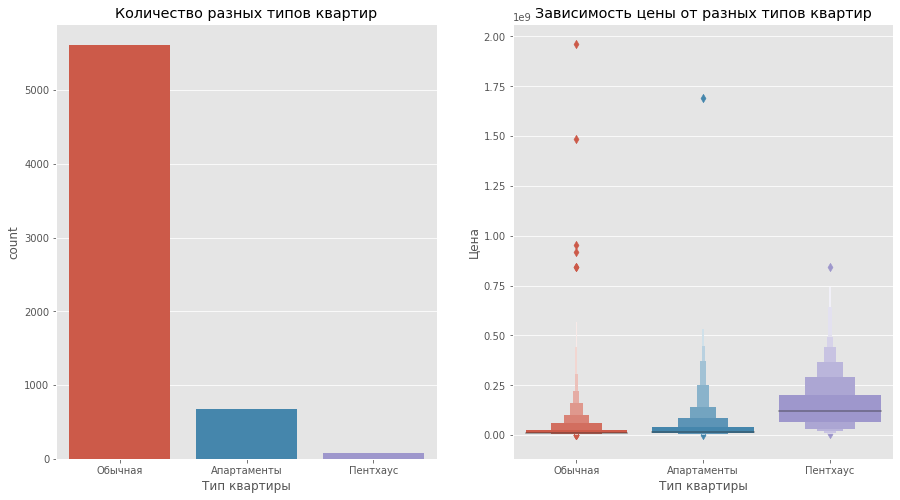

In [1008]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

sns.countplot(df_train['Тип квартиры'], ax=axes[0])
sns.boxenplot(x=df_train['Тип квартиры'], y=df_train['Цена'], ax=axes[1])

axes[0].set_title('Количество разных типов квартир')
axes[1].set_title('Зависимость цены от разных типов квартир')

plt.show()

In [1009]:
df_train['Тип квартиры'] = df_train['Тип квартиры'] \
.map({'Обычная': 'Обычная', 'Апартаменты': 'Апартаменты+Пентхаус', 'Пентхаус': 'Апартаменты+Пентхаус'})

df_test['Тип квартиры'] = df_test['Тип квартиры'] \
.map({'Обычная': 'Обычная', 'Апартаменты': 'Апартаменты+Пентхаус', 'Пентхаус': 'Апартаменты+Пентхаус'})

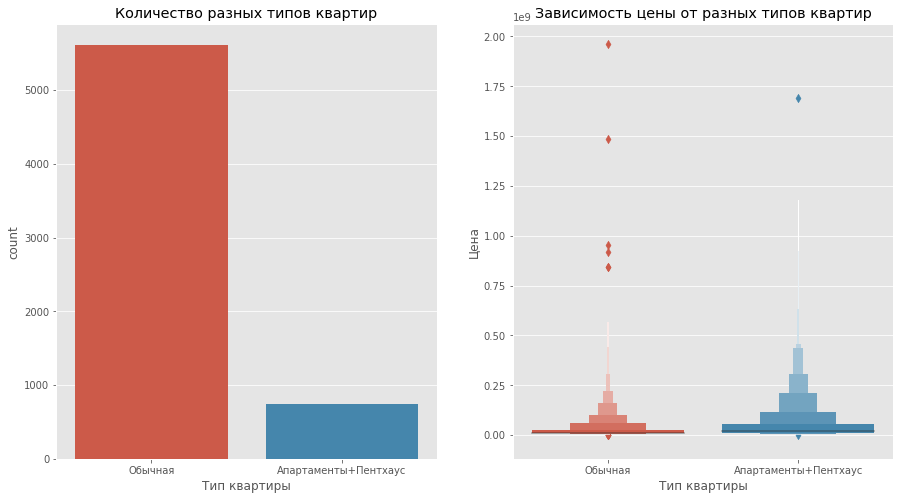

In [1010]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

sns.countplot(df_train['Тип квартиры'], ax=axes[0])
sns.boxenplot(x=df_train['Тип квартиры'], y=df_train['Цена'], ax=axes[1])

axes[0].set_title('Количество разных типов квартир')
axes[1].set_title('Зависимость цены от разных типов квартир')

plt.show()

Создаю два новых признака <b>"Метро в кольце"</b> и <b>"Есть метро"</b>. Есть гипотеза, что квартиры, находящиеся в кольце, дороже, да и метро слишком много, чтобы иметь их все в качестве признаков. Тоже самое относится и к признаку "Есть метро".

In [1011]:
df_train['Метро 1'].unique()

array(['Бульвар Рокоссовского', 'Севастопольская',
       'Улица Академика Янгеля', 'Строгино', 'Алексеевская',
       'Алма-Атинская', 'Чистые пруды', 'Ясенево', 'Некрасовка',
       'Хорошево', 'Шаболовская', 'Проспект Вернадского',
       'Улица Дмитриевского', 'Полянка', 'Верхние котлы', 'Тверская',
       'Выставочная', 'Кунцевская', 'Аэропорт', 'Выхино', 'Кропоткинская',
       'Тимирязевская', 'Силикатная', 'Лихоборы', 'Динамо',
       'Братиславская', 'Автозаводская', 'Киевская', 'Бескудниково',
       'Домодедовская', 'Водный стадион', 'Минская', 'Марьина роща',
       'Бауманская', 'Улица Народного Ополчения', 'Воробьевы горы',
       'Ховрино', 'Октябрьское поле', 'Щукинская', 'Панфиловская',
       'Павелецкая', 'Полежаевская', 'Арбатская', 'Молодежная',
       'Авиамоторная', 'Улица 800-летия Москвы', 'Технопарк', nan,
       'Селигерская', 'Академическая', 'Юго-Западная', 'Фрунзенская',
       'Парк Победы', 'Ботанический сад', 'Пятницкое шоссе', 'Алтуфьево',
       'Курс

In [1012]:
metro = pd.read_csv('metro.csv', names=['Метро'])

In [1013]:
df_train['Метро 1'].fillna('Нет', inplace=True)
df_train['Метро в кольце'] = df_train['Метро 1']

df_test['Метро 1'].fillna('Нет', inplace=True)
df_test['Метро в кольце'] = df_test['Метро 1']

In [1014]:
for elem in [df_train, df_test]:
    for i in range(elem.shape[0]):
        if elem.loc[i]['Метро 1'] in metro['Метро'].values or elem.loc[i]['Метро 2'] in metro['Метро'].values:
            elem.loc[i, 'Метро в кольце'] = 'Да'
        else:
            elem.loc[i, 'Метро в кольце'] = 'Нет'

In [1015]:
dict_for_metro = {num:('Нет' if num=='Нет' else 'Да') for num in \
                  (set(df_train['Метро 1'].values) | set(df_test['Метро 1'].values))}
df_train['Есть метро'] = df_train['Метро 1'].map(dict_for_metro)
df_test['Есть метро'] = df_test['Метро 1'].map(dict_for_metro)

df_train.drop(columns=['Метро 1', 'Метро 2'], inplace=True)
df_test.drop(columns=['Метро 1', 'Метро 2'], inplace=True)

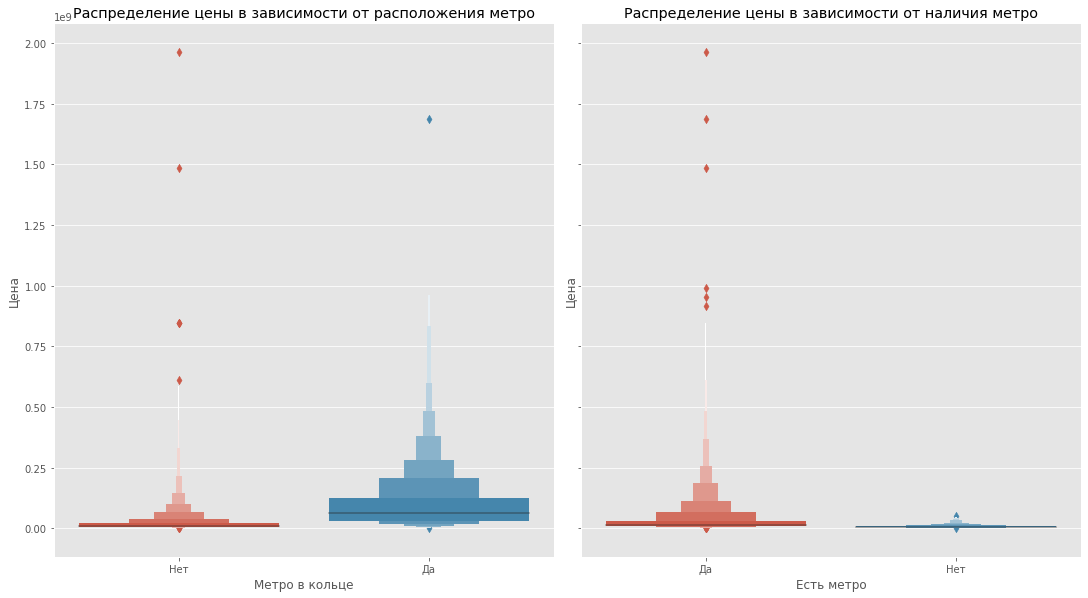

In [1016]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8), sharey=True)
plt.tight_layout()

sns.boxenplot(x=df_train['Метро в кольце'], y=df_train['Цена'], ax=axes[0])
sns.boxenplot(x=df_train['Есть метро'], y=df_train['Цена'], ax=axes[1])

axes[0].set_title('Распределение цены в зависимости от расположения метро')
axes[1].set_title('Распределение цены в зависимости от наличия метро')

plt.show()

In [1017]:
df_train.isnull().sum()

Количество комнат       0
Долгота                 0
Широта                  0
Высота потолков         0
Санузел                 0
Ремонт               2435
Общая                   0
Этаж                    0
Всего этажей            0
Жилая                   0
Кухня                   0
Тип дома             2312
Подъезды             3032
Отопление            3174
Мусоропровод            0
Цена                    0
Год                   624
Балкон                  0
Санузлов >= 2           0
Есть лифт               0
Вторичка              776
Тип квартиры            0
Метро в кольце          0
Есть метро              0
dtype: int64

Заменяю null в подъездах на медиану:

In [1018]:
df_train.groupby('Подъезды')['Общая'].count()

Подъезды
1.0     613
2.0     430
3.0     466
4.0     515
5.0     278
6.0     293
7.0     156
8.0     182
9.0      81
10.0     90
11.0     34
12.0     85
13.0     12
14.0     24
15.0     14
16.0      7
17.0      5
18.0     17
19.0      1
20.0      1
21.0     16
22.0      2
23.0      1
24.0      6
27.0      1
Name: Общая, dtype: int64

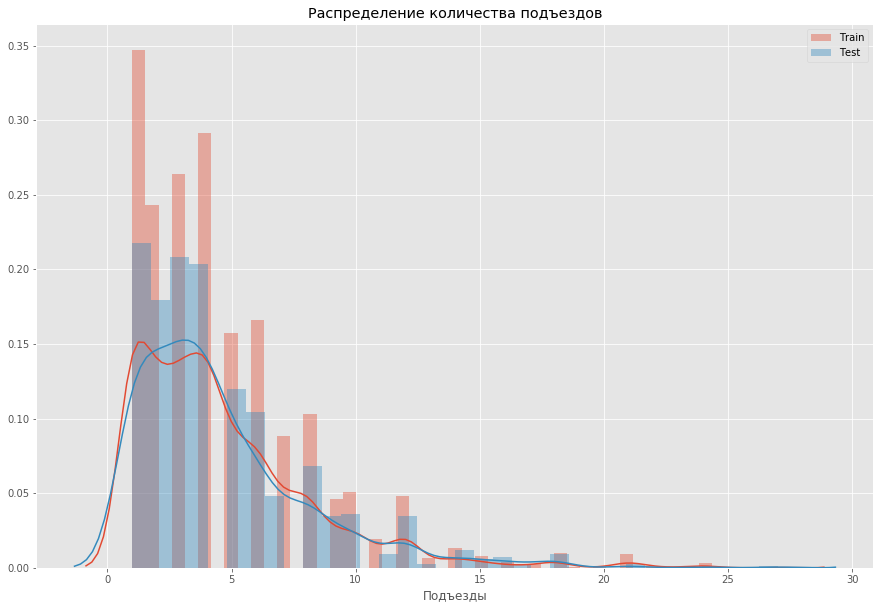

In [1019]:
plt.figure(figsize=(15,10))

sns.distplot(df_train[(~df_train['Подъезды'].isnull())]['Подъезды'], label='Train')
sns.distplot(df_test[(~df_test['Подъезды'].isnull())]['Подъезды'], label='Test')

plt.title('Распределение количества подъездов')
plt.legend()

plt.show()

In [1020]:
df_train['Подъезды'].fillna(value=df_train['Подъезды'].median(), inplace=True)
df_test['Подъезды'].fillna(value=df_train['Подъезды'].median(), inplace=True)

Так себе замена конечно, видно что распределение потеряло свой вид, но другого варианта не придумал:

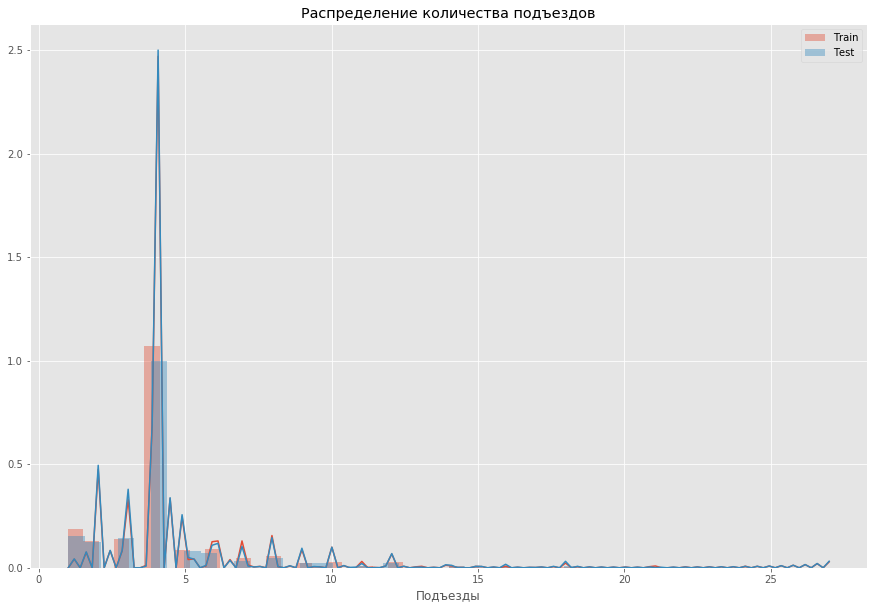

In [1021]:
plt.figure(figsize=(15,10))

sns.distplot(df_train['Подъезды'], label='Train')
sns.distplot(df_test['Подъезды'], label='Test')

plt.title('Распределение количества подъездов')
plt.legend()

plt.show()

Гипотеза такая, что разные типы домов выпускались в различные года. Сделаем замену пропущенных годов на основе этой гипотезы

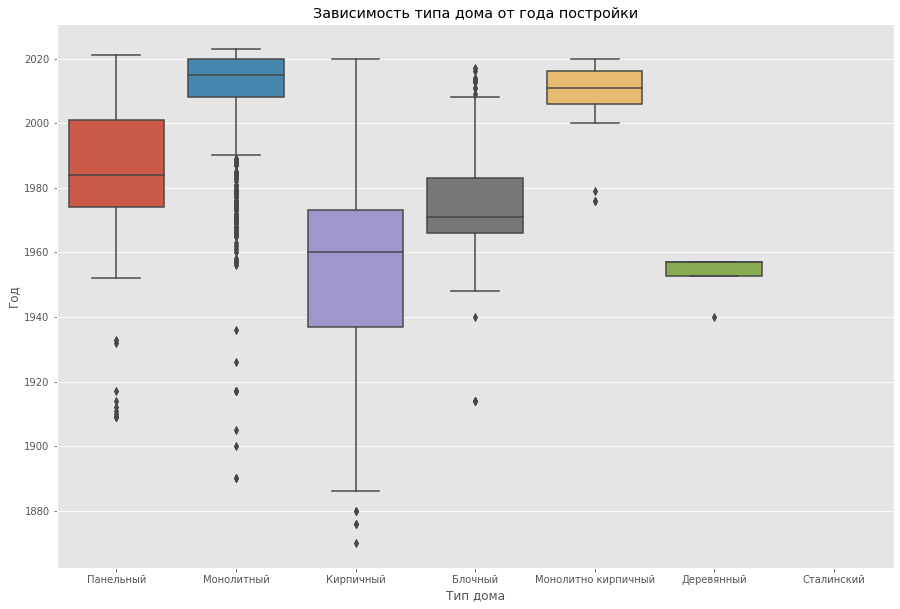

In [1022]:
plt.figure(figsize=(15,10))

sns.boxplot(x='Тип дома', y='Год', data=df_train)

plt.title('Зависимость типа дома от года постройки')
plt.show()

In [1023]:
df_train.groupby('Тип дома')['Год'].describe()

,count,mean,std,min,25%,50%,75%,max
Тип дома,,,,,,,,
Блочный,256.0,1976.246094,17.943211,1914.0,1966.00,1971.0,1983.0,2017.0
Деревянный,4.0,1952.750000,8.500000,1940.0,1952.75,1957.0,1957.0,1957.0
Кирпичный,701.0,1958.647646,32.082972,1870.0,1937.00,1960.0,1973.0,2020.0
Монолитно кирпичный,25.0,2007.640000,12.841599,1976.0,2006.00,2011.0,2016.0,2020.0
Монолитный,1978.0,2011.811426,12.791165,1890.0,2008.00,2015.0,2020.0,2023.0
Панельный,994.0,1986.752515,17.238482,1909.0,1974.00,1984.0,2001.0,2021.0
Сталинский,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1024]:
df_type_god = df_train.groupby('Тип дома')['Год'].median().reset_index()
df_type_god = df_type_god[~df_type_god['Год'].isnull()].set_index('Тип дома')
df_type_god

,Год
Тип дома,
Блочный,1971.0
Деревянный,1957.0
Кирпичный,1960.0
Монолитно кирпичный,2011.0
Монолитный,2015.0
Панельный,1984.0


In [1025]:
df_type_god.to_csv('df_type_god.csv')

In [1026]:
df_train = df_train.set_index('Тип дома')
df_train['Год'].fillna(df_type_god['Год'], inplace=True)

df_test = df_test.set_index('Тип дома')
df_test['Год'].fillna(df_type_god['Год'], inplace=True)

In [1027]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()

Теперь признак <b>"Отопление"</b>. Выделяю "Центральное" в основную группу, заменяю nan на центральное - наиболее встречающееся. Сам признак делаю бинарным - центральное отопление или нет.

In [1028]:
df_train.groupby('Отопление')['Общая'].count()

Отопление
Автономная котельная               99
Индивидуальный тепловой пункт     188
Котел/Квартирное отопление         11
Нет                                 2
Печь                                1
Центральное                      2887
Name: Общая, dtype: int64

In [1029]:
df_test.groupby('Отопление')['Общая'].count()

Отопление
Автономная котельная              23
Индивидуальный тепловой пункт     53
Котел/Квартирное отопление         4
Нет                                2
Центральное                      965
Name: Общая, dtype: int64

In [1030]:
df_train['Отопление'].fillna('Центральное', inplace=True)
df_test['Отопление'].fillna('Центральное', inplace=True)

In [1031]:
df_train['Отопление'].unique(), df_test['Отопление'].unique()

(array(['Центральное', 'Автономная котельная',
        'Индивидуальный тепловой пункт', 'Котел/Квартирное отопление',
        'Нет', 'Печь'], dtype=object),
 array(['Центральное', 'Автономная котельная',
        'Индивидуальный тепловой пункт', 'Нет',
        'Котел/Квартирное отопление'], dtype=object))

In [1032]:
df_train['Центральное отопление'] = df_train['Отопление'].map({i:(1 if i == 'Центральное' else 0) for i in df_train['Отопление'].unique()})
df_test['Центральное отопление'] = df_test['Отопление'].map({i:(1 if i == 'Центральное' else 0) for i in df_test['Отопление'].unique()})

df_train.drop(columns=['Отопление'], inplace=True)
df_test.drop(columns=['Отопление'], inplace=True)

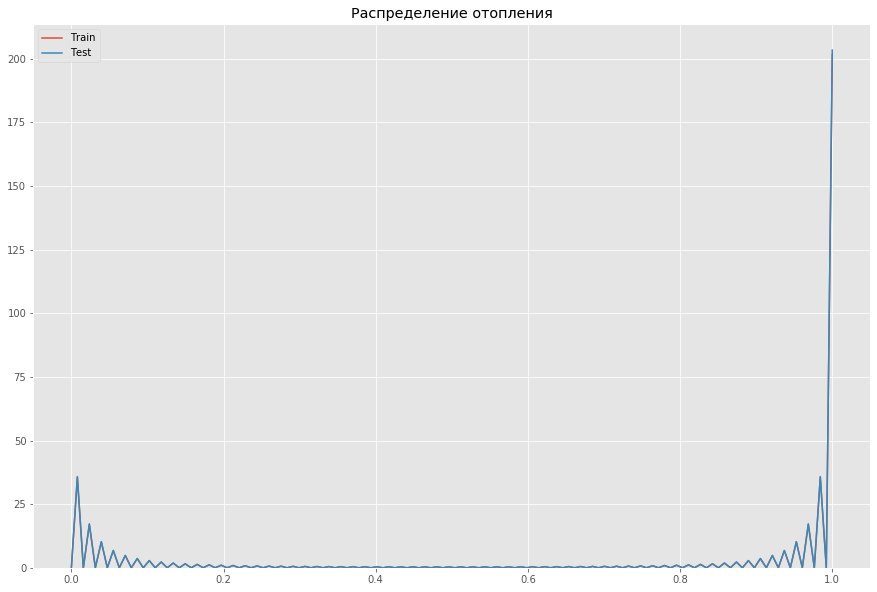

In [1033]:
plt.figure(figsize=(15,10))

sns.kdeplot(df_train['Центральное отопление'], label='Train')
sns.kdeplot(df_test['Центральное отопление'], label='Test')

plt.title('Распределение отопления')
plt.show()

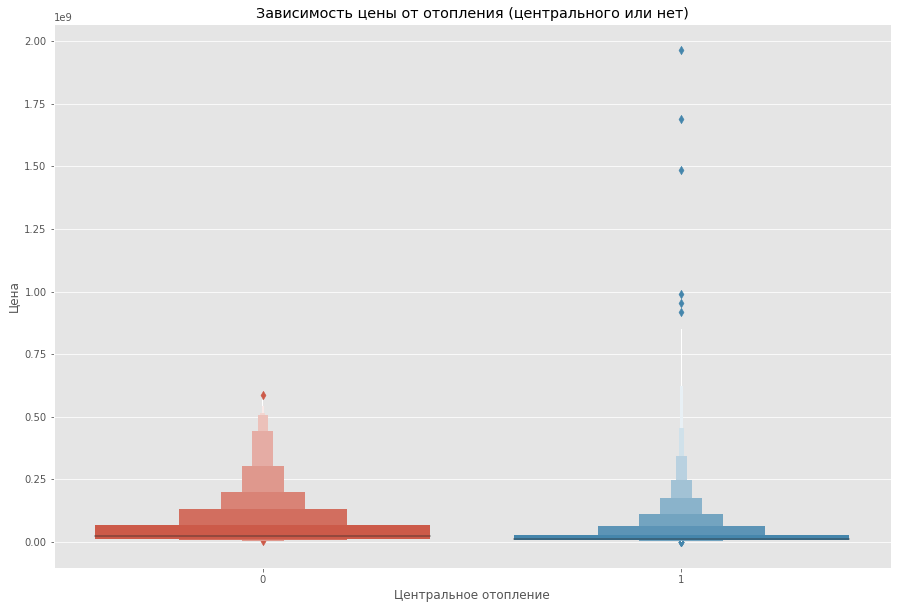

In [1034]:
plt.figure(figsize=(15,10))

sns.boxenplot(x='Центральное отопление', y='Цена', data=df_train)

plt.title('Зависимость цены от отопления (центрального или нет)')
plt.show()

In [1035]:
df_train.isnull().sum()

Тип дома                 2312
Количество комнат           0
Долгота                     0
Широта                      0
Высота потолков             0
Санузел                     0
Ремонт                   2435
Общая                       0
Этаж                        0
Всего этажей                0
Жилая                       0
Кухня                       0
Подъезды                    0
Мусоропровод                0
Цена                        0
Год                       533
Балкон                      0
Санузлов >= 2               0
Есть лифт                   0
Вторичка                  776
Тип квартиры                0
Метро в кольце              0
Есть метро                  0
Центральное отопление       0
dtype: int64

Остались <b>null во вторичке (вторичка/новостройка)</b>. Есть гипотеза, что дом новостройка - построен позже, чем вторичка. В принципе логично. Сделаем на основе этого замену. Тем домам, у которых год > 2019 присвоим новостройка, иначе вторичка.

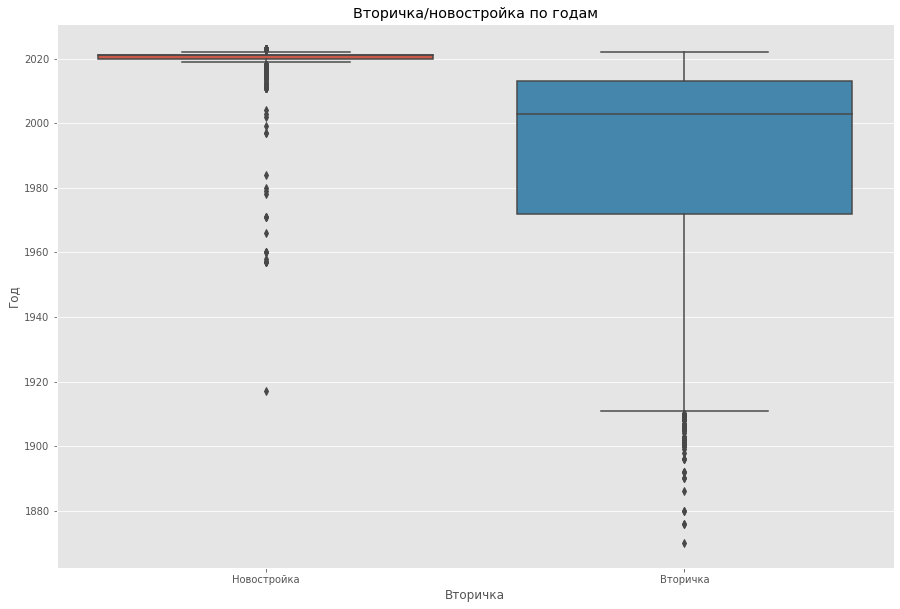

In [1036]:
plt.figure(figsize=(15,10))

sns.boxplot(x=df_train.Вторичка, y=df_train.Год)
plt.title('Вторичка/новостройка по годам')

plt.show()

In [1037]:
df_train.groupby('Вторичка')['Год'].mean()

Вторичка
Вторичка       1990.913442
Новостройка    2019.366562
Name: Год, dtype: float64

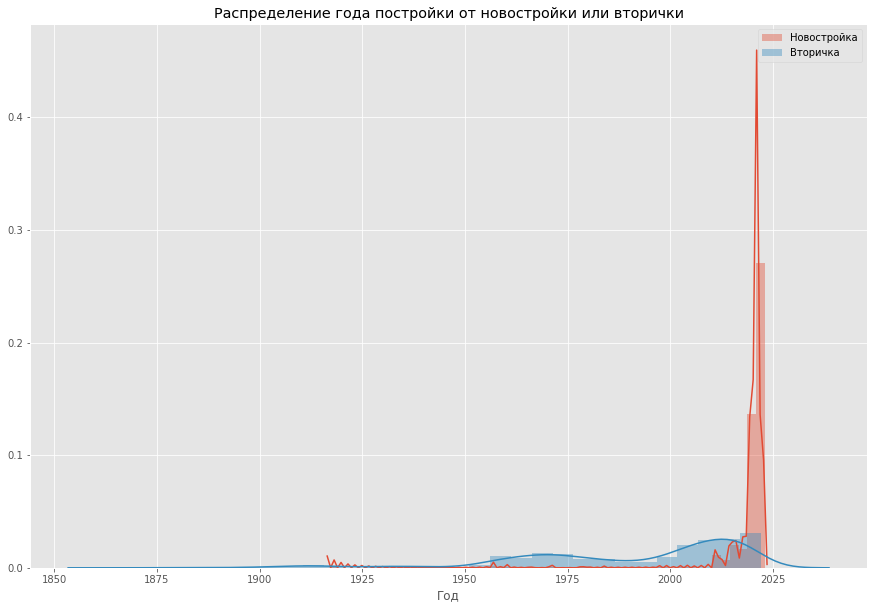

In [1038]:
plt.figure(figsize=(15,10))

sns.distplot(df_train[(df_train.Вторичка=='Новостройка') & (~df_train.Год.isnull())]['Год'], label='Новостройка')
sns.distplot(df_train[(df_train.Вторичка=='Вторичка') & (~df_train.Год.isnull())]['Год'], label='Вторичка')

plt.title('Распределение года постройки от новостройки или вторички')
plt.legend()

plt.show()

In [1039]:
df_train.loc[df_train['Вторичка'].isnull(), 'Вторичка'] = np.where(df_train[df_train['Вторичка'].isnull()]['Год'] > 2019, 'Новостройка', 'Вторичка')
df_test.loc[df_test['Вторичка'].isnull(), 'Вторичка'] = np.where(df_test[df_test['Вторичка'].isnull()]['Год'] > 2019, 'Новостройка', 'Вторичка')

Сделаем замену оставшихся null-ов в годах постройки на медиану этого признака:

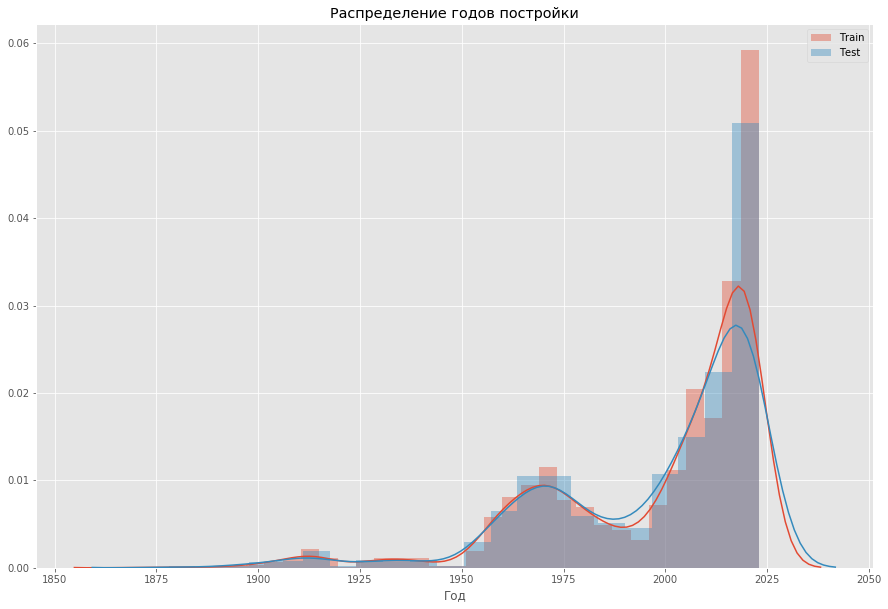

In [1040]:
plt.figure(figsize=(15,10))

sns.distplot(df_train[~df_train['Год'].isnull()]['Год'], label='Train')
sns.distplot(df_test[~df_test['Год'].isnull()]['Год'], label='Test')

plt.title('Распределение годов постройки')
plt.legend()

plt.show()

In [1041]:
df_test['Год'].mean(), df_train['Год'].mean(), df_test['Год'].median(), df_train['Год'].median()

(1997.6483402489628, 1997.8229541945445, 2008.0, 2009.0)

In [1042]:
df_train = df_train.drop(df_train.loc[df_train['Тип дома']=='Сталинский'].index)
df_test = df_test.drop(df_test.loc[df_test['Тип дома']=='Сталинский'].index)

In [1043]:
df_train['Год'].fillna(df_train['Год'].median(), inplace=True)
df_test['Год'].fillna(df_train['Год'].median(), inplace=True)

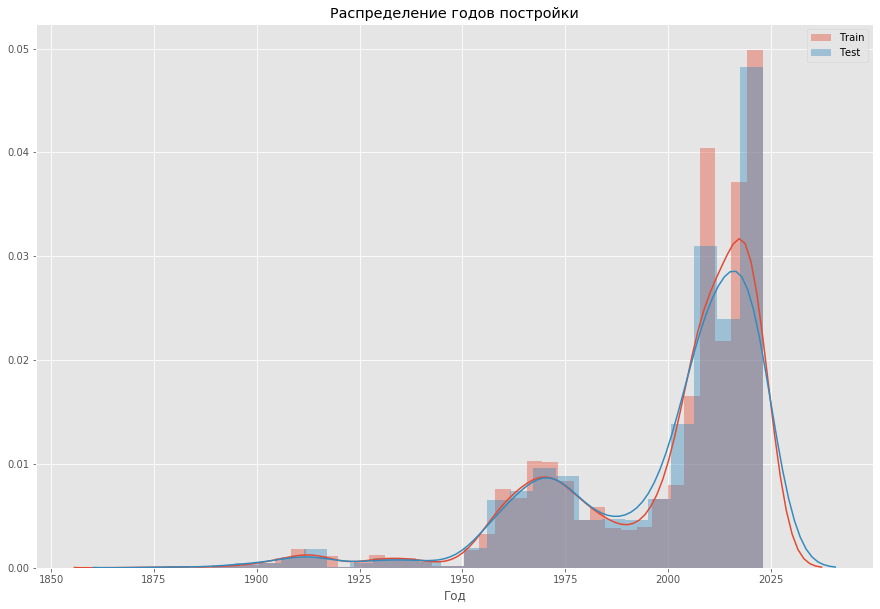

In [1044]:
plt.figure(figsize=(15,10))

sns.distplot(df_train['Год'], label='Train')
sns.distplot(df_test['Год'], label='Test')

plt.title('Распределение годов постройки')
plt.legend()

plt.show()

Остались null в типе квартиры и в ремонте:

In [1045]:
df_train.isnull().sum()

Тип дома                 2312
Количество комнат           0
Долгота                     0
Широта                      0
Высота потолков             0
Санузел                     0
Ремонт                   2435
Общая                       0
Этаж                        0
Всего этажей                0
Жилая                       0
Кухня                       0
Подъезды                    0
Мусоропровод                0
Цена                        0
Год                         0
Балкон                      0
Санузлов >= 2               0
Есть лифт                   0
Вторичка                    0
Тип квартиры                0
Метро в кольце              0
Есть метро                  0
Центральное отопление       0
dtype: int64

Посмотрим на медиану годов постройки в зависимости от ремонта. В принципе видно, что есть определенная тенденция:

In [1046]:
df_train.groupby('Ремонт')['Год'].agg(Год='median')

,Год
Ремонт,
Без ремонта,2012.0
Дизайнерский,2008.0
Евроремонт,2002.0
Косметический,1979.0


In [1047]:
df_train.groupby('Вторичка').count()

,Тип дома,Количество комнат,Долгота,Широта,Высота потолков,Санузел,Ремонт,Общая,Этаж,Всего этажей,...,Мусоропровод,Цена,Год,Балкон,Санузлов >= 2,Есть лифт,Тип квартиры,Метро в кольце,Есть метро,Центральное отопление
Вторичка,,,,,,,,,,,,,,,,,,,,,
Вторичка,3330,4874,4874,4874,4874,4874,3890,4874,4874,4874,...,4874,4874,4874,4874,4874,4874,4874,4874,4874,4874
Новостройка,719,1487,1487,1487,1487,1487,36,1487,1487,1487,...,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487


In [1048]:
df_train[(df_train['Ремонт'].isnull()) & (df_train['Вторичка'] == 'Новостройка')]

,Тип дома,Количество комнат,Долгота,Широта,Высота потолков,Санузел,Ремонт,Общая,Этаж,Всего этажей,...,Цена,Год,Балкон,Санузлов >= 2,Есть лифт,Вторичка,Тип квартиры,Метро в кольце,Есть метро,Центральное отопление
0,NaN,1,37.7423,55.8109,2.90,1.0,NaN,39.0,16,22,...,10001567.0,2009.0,1,0,1,Новостройка,Обычная,Нет,Да,1
5,NaN,2,37.635,55.8077,2.95,1.0,NaN,75.5,9,15,...,20295478.0,2020.0,0,0,1,Новостройка,Апартаменты+Пентхаус,Нет,Да,1
25,NaN,4,37.5619,55.786,2.95,4.0,NaN,107.9,20,21,...,39026998.0,2019.0,1,1,1,Новостройка,Обычная,Нет,Да,1
29,NaN,2,37.5432,55.8809,2.95,1.0,NaN,53.6,12,24,...,9350000.0,2020.0,1,0,1,Новостройка,Обычная,Нет,Да,1
31,NaN,1,37.7305,55.6023,2.80,1.0,NaN,20.0,16,25,...,5850000.0,2020.0,0,0,1,Новостройка,Обычная,Нет,Да,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,NaN,1,37.7763,55.7996,3.10,1.0,NaN,39.5,2,19,...,8500000.0,2009.0,1,0,1,Новостройка,Обычная,Нет,Да,1
6353,Монолитный,2,37.3224,55.5043,2.95,1.0,NaN,49.9,2,13,...,7240833.0,2021.0,1,0,1,Новостройка,Обычная,Нет,Да,1
6354,Монолитный,1,37.5685,55.6517,3.10,1.0,NaN,45.7,2,32,...,14532600.0,2020.0,0,0,1,Новостройка,Обычная,Нет,Да,1
6360,Монолитный,1,37.7053,55.6457,2.40,1.0,NaN,25.5,3,19,...,5600000.0,2021.0,1,0,1,Новостройка,Обычная,Нет,Да,1


In [1049]:
df_train.pivot_table(['Цена'], ['Вторичка', 'Ремонт'], aggfunc=['median', 'count'])

median count
                                 Цена  Цена
Вторичка    Ремонт                         
Вторичка    Без ремонта    21000000.0   963
            Дизайнерский   39850000.0   833
            Евроремонт     13900000.0   870
            Косметический   8700000.0  1224
Новостройка Без ремонта     9931810.0     6
            Дизайнерский   16940420.0    10
            Евроремонт     17334898.0    13
            Косметический  25704000.0     7

Сделаем замену, что если квартира в новостройке, то вероятнее всего она без ремонта, а все что не попало то определяем в группу "другое":

In [1050]:
df_train.loc[df_train['Ремонт'].isnull(), 'Ремонт'] = np.where(df_train[df_train['Ремонт'].isnull()]['Вторичка'] == 'Новостройка', 'Без ремонта', 'Другое')
df_test.loc[df_test['Ремонт'].isnull(), 'Ремонт'] = np.where(df_test[df_test['Ремонт'].isnull()]['Вторичка'] == 'Новостройка', 'Без ремонта', 'Другое')

In [1051]:
df_train.pivot_table(['Цена'], ['Вторичка', 'Ремонт'], aggfunc=['median', 'count'])

median count
                                 Цена  Цена
Вторичка    Ремонт                         
Вторичка    Без ремонта    21000000.0   963
            Дизайнерский   39850000.0   833
            Другое         11200000.0   984
            Евроремонт     13900000.0   870
            Косметический   8700000.0  1224
Новостройка Без ремонта    13441647.0  1457
            Дизайнерский   16940420.0    10
            Евроремонт     17334898.0    13
            Косметический  25704000.0     7

Посмотрим на распределение годов построек в зависимости от ремонта:

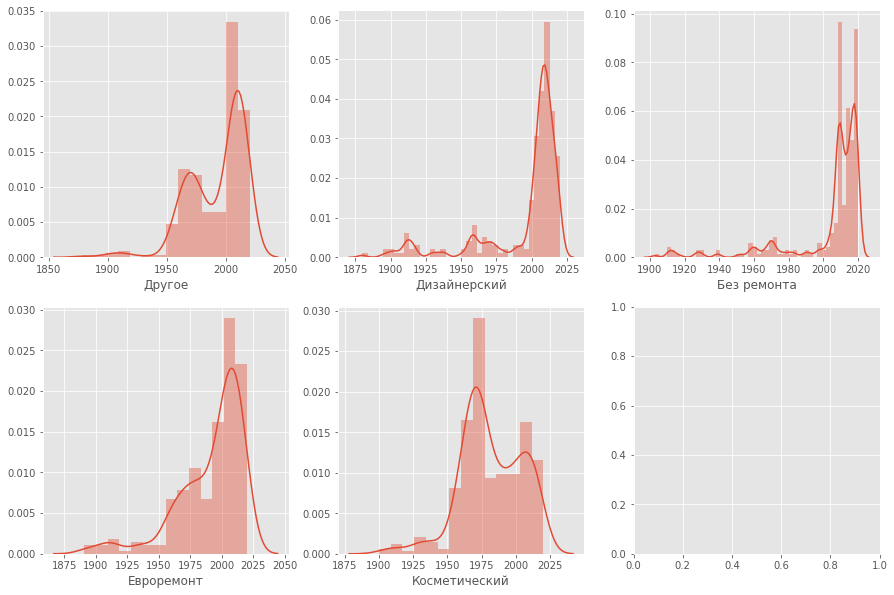

In [1052]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

sns.distplot(df_test[(df_test['Вторичка'] == 'Вторичка') & (df_test['Ремонт']=='Другое')]['Год'], ax=axes[0, 0], axlabel='Другое')
sns.distplot(df_test[(df_test['Вторичка'] == 'Вторичка') & (df_test['Ремонт']=='Дизайнерский')]['Год'], ax=axes[0, 1], axlabel='Дизайнерский')
sns.distplot(df_test[(df_test['Вторичка'] == 'Вторичка') & (df_test['Ремонт']=='Без ремонта')]['Год'], ax=axes[0, 2], axlabel='Без ремонта')
sns.distplot(df_test[(df_test['Вторичка'] == 'Вторичка') & (df_test['Ремонт']=='Евроремонт')]['Год'], ax=axes[1, 0], axlabel='Евроремонт')
sns.distplot(df_test[(df_test['Вторичка'] == 'Вторичка') & (df_test['Ремонт']=='Косметический')]['Год'], ax=axes[1, 1], axlabel='Косметический')

plt.show()

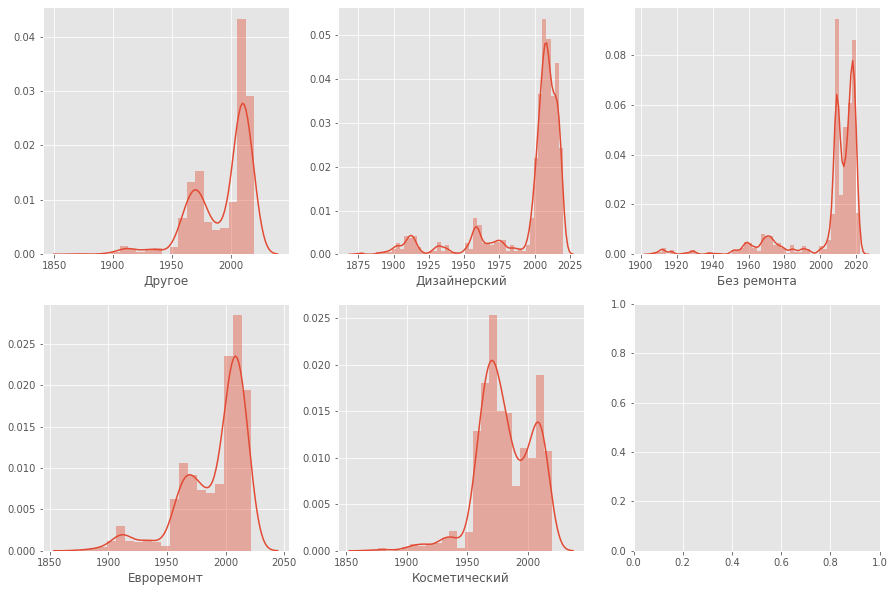

In [1053]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

sns.distplot(df_train[(df_train['Вторичка'] == 'Вторичка') & (df_train['Ремонт']=='Другое')]['Год'], ax=axes[0, 0], axlabel='Другое')
sns.distplot(df_train[(df_train['Вторичка'] == 'Вторичка') & (df_train['Ремонт']=='Дизайнерский')]['Год'], ax=axes[0, 1], axlabel='Дизайнерский')
sns.distplot(df_train[(df_train['Вторичка'] == 'Вторичка') & (df_train['Ремонт']=='Без ремонта')]['Год'], ax=axes[0, 2], axlabel='Без ремонта')
sns.distplot(df_train[(df_train['Вторичка'] == 'Вторичка') & (df_train['Ремонт']=='Евроремонт')]['Год'], ax=axes[1, 0], axlabel='Евроремонт')
sns.distplot(df_train[(df_train['Вторичка'] == 'Вторичка') & (df_train['Ремонт']=='Косметический')]['Год'], ax=axes[1, 1], axlabel='Косметический')\

plt.show()

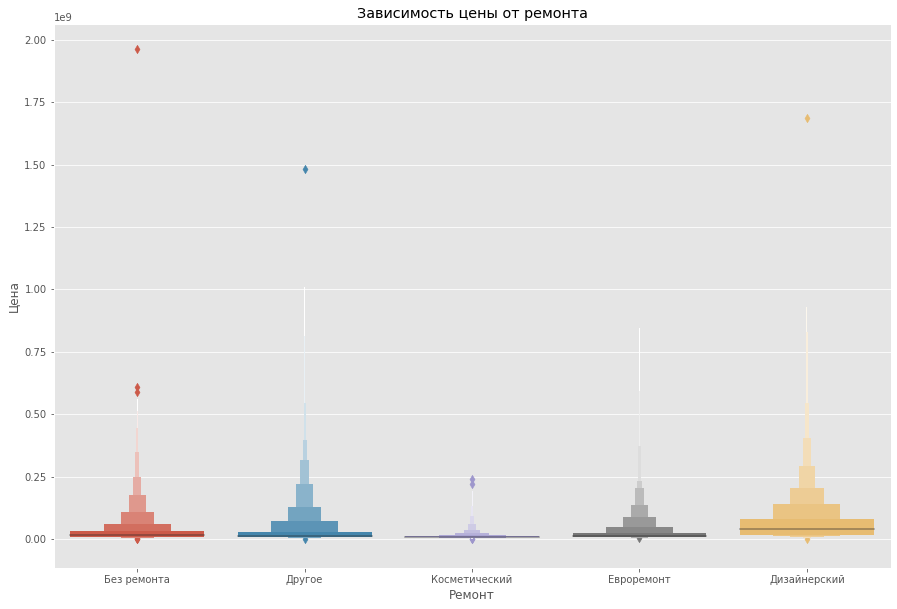

In [1054]:
plt.figure(figsize=(15,10))

sns.boxenplot(x=df_train['Ремонт'], y=df_train['Цена'])

plt.title('Зависимость цены от ремонта')
plt.show()

Посчитаем <b>расстояние</b> от каждого объекта на основе долготы и широты до двух важных точек: <b>Красная площадь и Москва Сити.</b>

In [1055]:
from math import cos, asin, sqrt

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295   
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) 

In [1056]:
red_square = []
moscow_city = []

for lat1, lon1 in zip(df_train.Широта, df_train.Долгота):
    red_square.append(distance(lat1, lon1, lat2 = 55.753585, lon2 = 37.621085))
    moscow_city.append(distance(lat1, lon1, lat2 = 55.749420, lon2 = 37.537996))
    
df_train = df_train.assign(До_красной_площади = red_square)
df_train = df_train.assign(До_Москва_сити = moscow_city)

In [1057]:
red_square = []
moscow_city = []

for lat1, lon1 in zip(df_test.Широта, df_test.Долгота):
    red_square.append(distance(lat1, lon1, lat2=55.753585, lon2=37.621085))
    moscow_city.append(distance(lat1, lon1, lat2=55.749420, lon2=37.537996))
    
df_test = df_test.assign(До_красной_площади=red_square)
df_test = df_test.assign(До_Москва_сити=moscow_city)

В принципе видна связь между ценой и удаленностью (квартиры с высокими ценами смещены в левую сторону):

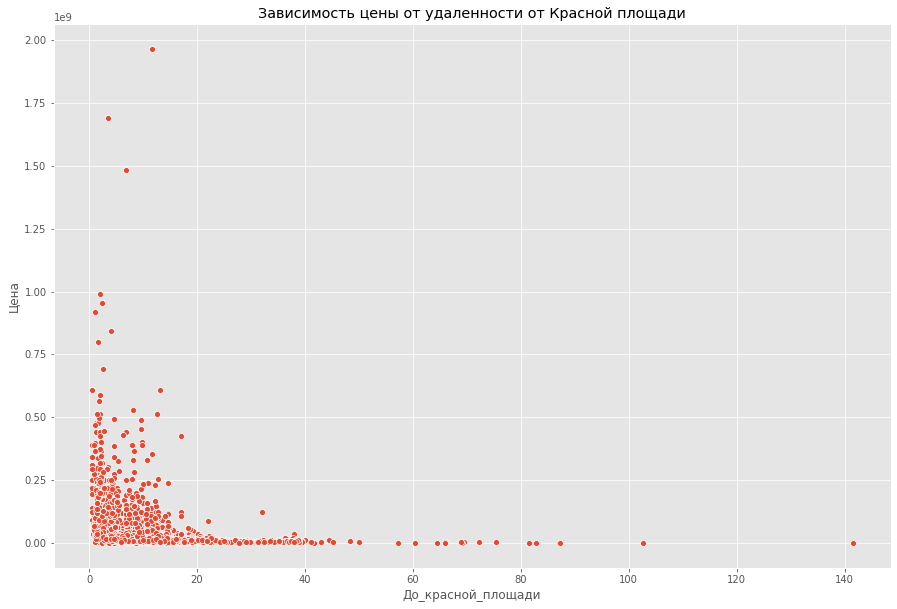

In [1058]:
plt.figure(figsize=(15,10))

sns.scatterplot(df_train.До_красной_площади, df_train.Цена)

plt.title('Зависимость цены от удаленности от Красной площади')
plt.show()

In [1059]:
df_train.rename(columns={'Санузел': 'Количество санузлов', 'Общая': 'Общая площадь', 'Жилая': 'Жилая площадь', 'Кухня': 'Площадь кухни', 'Балкон': 'Количество балконов'}, inplace=True)
df_test.rename(columns={'Санузел': 'Количество санузлов', 'Общая': 'Общая площадь', 'Жилая': 'Жилая площадь', 'Кухня': 'Площадь кухни', 'Балкон': 'Количество балконов'}, inplace=True)

df_train.drop(columns=['Тип дома'], inplace=True)
df_test.drop(columns=['Тип дома'], inplace=True)

Какие признаки получились в итоге:

In [1060]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 2120
Data columns (total 25 columns):
Количество комнат        2121 non-null object
Долгота                  2121 non-null object
Широта                   2121 non-null object
Высота потолков          2121 non-null float64
Количество санузлов      2121 non-null float64
Ремонт                   2121 non-null object
Общая площадь            2121 non-null float64
Этаж                     2121 non-null object
Всего этажей             2121 non-null int64
Жилая площадь            2121 non-null float64
Площадь кухни            2121 non-null float64
Подъезды                 2121 non-null float64
Мусоропровод             2121 non-null int64
Цена                     2121 non-null float64
Год                      2121 non-null float64
Количество балконов      2121 non-null int64
Санузлов >= 2            2121 non-null int64
Есть лифт                2121 non-null int64
Вторичка                 2121 non-null object
Тип квартиры    

In [1061]:
df_train

,Количество комнат,Долгота,Широта,Высота потолков,Количество санузлов,Ремонт,Общая площадь,Этаж,Всего этажей,Жилая площадь,...,Количество балконов,Санузлов >= 2,Есть лифт,Вторичка,Тип квартиры,Метро в кольце,Есть метро,Центральное отопление,До_красной_площади,До_Москва_сити
0,1,37.7423,55.8109,2.90,1.0,Без ремонта,39.0,16,22,16.4,...,1,0,1,Новостройка,Обычная,Нет,Да,1,9.905741,14.492476
1,5,37.5974,55.6508,2.95,1.0,Другое,132.0,18,18,107.0,...,0,0,1,Вторичка,Обычная,Нет,Да,1,11.521253,11.576523
2,1,37.7598,55.8275,2.64,1.0,Без ремонта,30.3,3,5,19.1,...,1,0,0,Вторичка,Обычная,Нет,Да,1,11.944105,16.357333
3,2,37.5994,55.5934,2.64,1.0,Косметический,44.0,8,25,33.7,...,1,0,1,Вторичка,Обычная,Нет,Да,1,17.859253,17.765730
4,2,37.3953,55.8169,2.64,1.0,Евроремонт,54.0,6,17,30.0,...,1,0,1,Вторичка,Обычная,Нет,Да,1,15.776367,11.659536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6357,2,37.329,55.5505,2.95,1.0,Косметический,50.6,1,3,25.0,...,1,0,0,Вторичка,Обычная,Нет,Да,0,29.083043,25.715347
6358,3,37.693,55.7482,3.20,1.0,Без ремонта,70.9,8,13,38.8,...,1,0,1,Вторичка,Обычная,Нет,Да,1,4.539176,9.701177
6359,2,37.4258,55.7374,2.95,1.0,Косметический,59.7,9,10,30.9,...,2,0,1,Вторичка,Обычная,Нет,Да,1,12.356186,7.150636
6360,1,37.7053,55.6457,2.40,1.0,Без ремонта,25.5,3,19,15.0,...,1,0,1,Новостройка,Обычная,Нет,Да,1,13.107841,15.589016


In [1067]:
obj_cols = df_train.select_dtypes(include='object')

for col in obj_cols:
    df_train[col] = df_train[col].astype('float')
    df_test[col] = df_test[col].astype('float')

- <b>Числовые:</b> количество комнат, долгота, широта, высота потолков, количество санузлов, общая площадь, этаж, всего этажей, жилая площадь, площадь кухни, подъезды, год, количество балконов, до_красной_площади, до_москва_сити 
- <b>Категориальные:</b> ремонт, тип квартиры, вторичка
- <b>Бинарные:</b> центральное отопление, есть лифт, санузлов >= 2, мусоропровод, есть метро, метро в кольце

Закодируем несколько бинарных признаков

In [1063]:
from sklearn.preprocessing import OrdinalEncoder

In [1064]:
encoder = OrdinalEncoder()

df_train['Есть метро'] = encoder.fit_transform(np.array(df_train['Есть метро']).reshape(-1,1))
df_test['Есть метро'] = encoder.fit_transform(np.array(df_test['Есть метро']).reshape(-1,1))

df_train['Метро в кольце'] = encoder.fit_transform(np.array(df_train['Метро в кольце']).reshape(-1,1))
df_test['Метро в кольце'] = encoder.fit_transform(np.array(df_test['Метро в кольце']).reshape(-1,1))

Закодируем категориальные признаки:

In [1065]:
df_train = pd.get_dummies(df_train, columns=['Ремонт', 'Вторичка', 'Тип квартиры'])
df_test = pd.get_dummies(df_test, columns=['Ремонт', 'Вторичка', 'Тип квартиры'])

In [1066]:
df_train.shape, df_test.shape

((6361, 31), (2121, 31))

In [1068]:
perestanovka =  sorted([i for i in df_train.columns if i != 'Цена'])
perestanovka.append('Цена')

df_train, df_test = df_train[perestanovka], df_test[perestanovka]

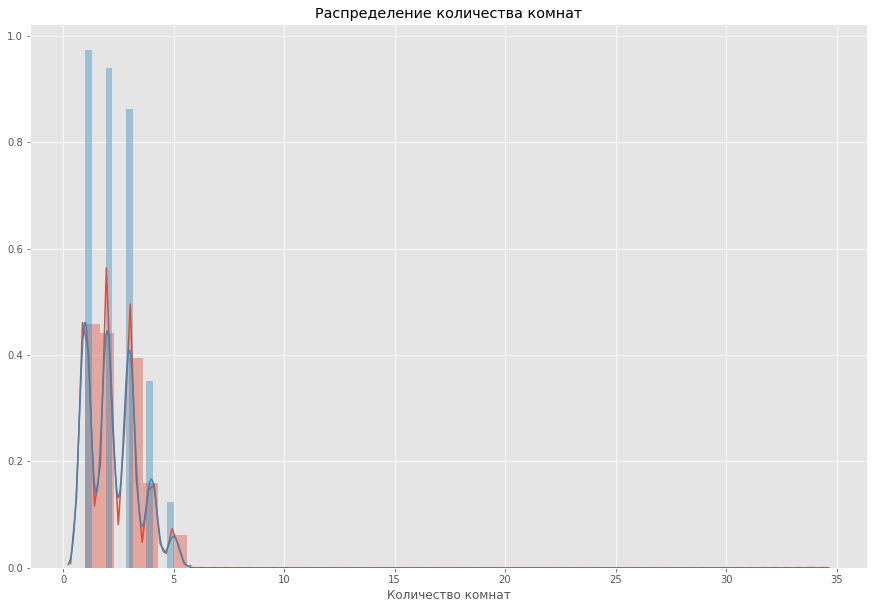

In [1069]:
plt.figure(figsize=(15,10))

sns.distplot(df_train['Количество комнат'], label='Train')
sns.distplot(df_test['Количество комнат'], label='Test')

plt.title('Распределение количества комнат')
plt.show()

In [1070]:
df_train = df_train.drop(df_train[df_train['Количество комнат'] == 34].index)

Посмотрим на распределение цены. Сильный правый хвост, после тестирования модели было принято решение ограничиться максимальной ценой в 50млн.

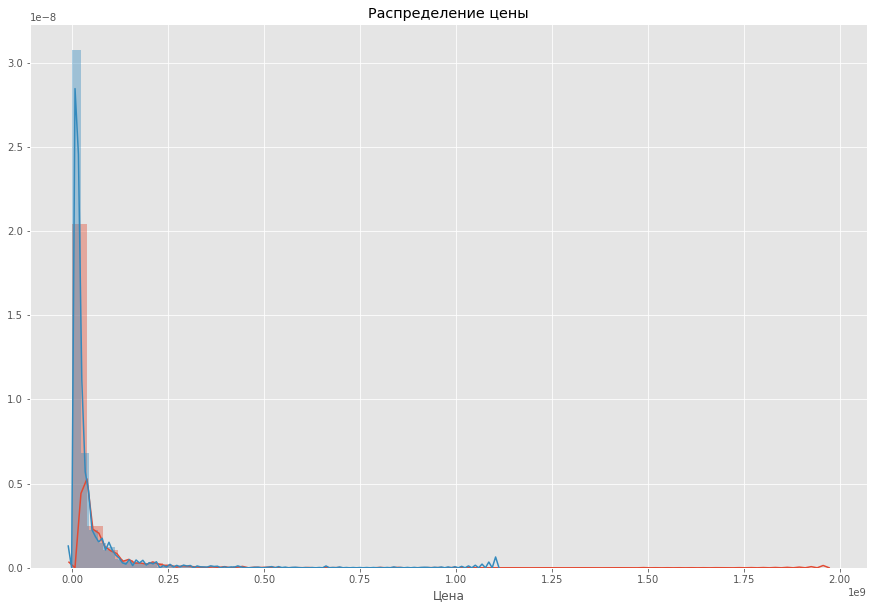

In [1071]:
plt.figure(figsize=(15,10))

sns.distplot(df_train['Цена'], label='Train')
sns.distplot(df_test['Цена'], label='Test')

plt.title('Распределение цены')
plt.show()

In [1072]:
df_train = df_train.drop(df_train[df_train.Цена > 50000000].index)
df_test = df_test.drop(df_test[df_test.Цена > 50000000].index)

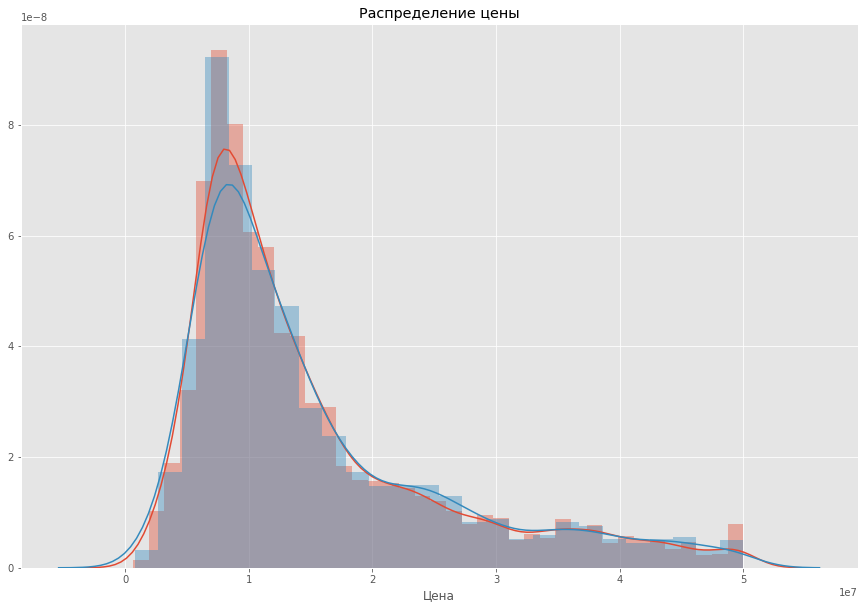

In [1073]:
plt.figure(figsize=(15,10))

sns.distplot(df_train['Цена'], label='Train')
sns.distplot(df_test['Цена'], label='Test')

plt.title('Распределение цены')
plt.show()

In [1074]:
df_train.shape, df_test.shape

((5349, 31), (1799, 31))

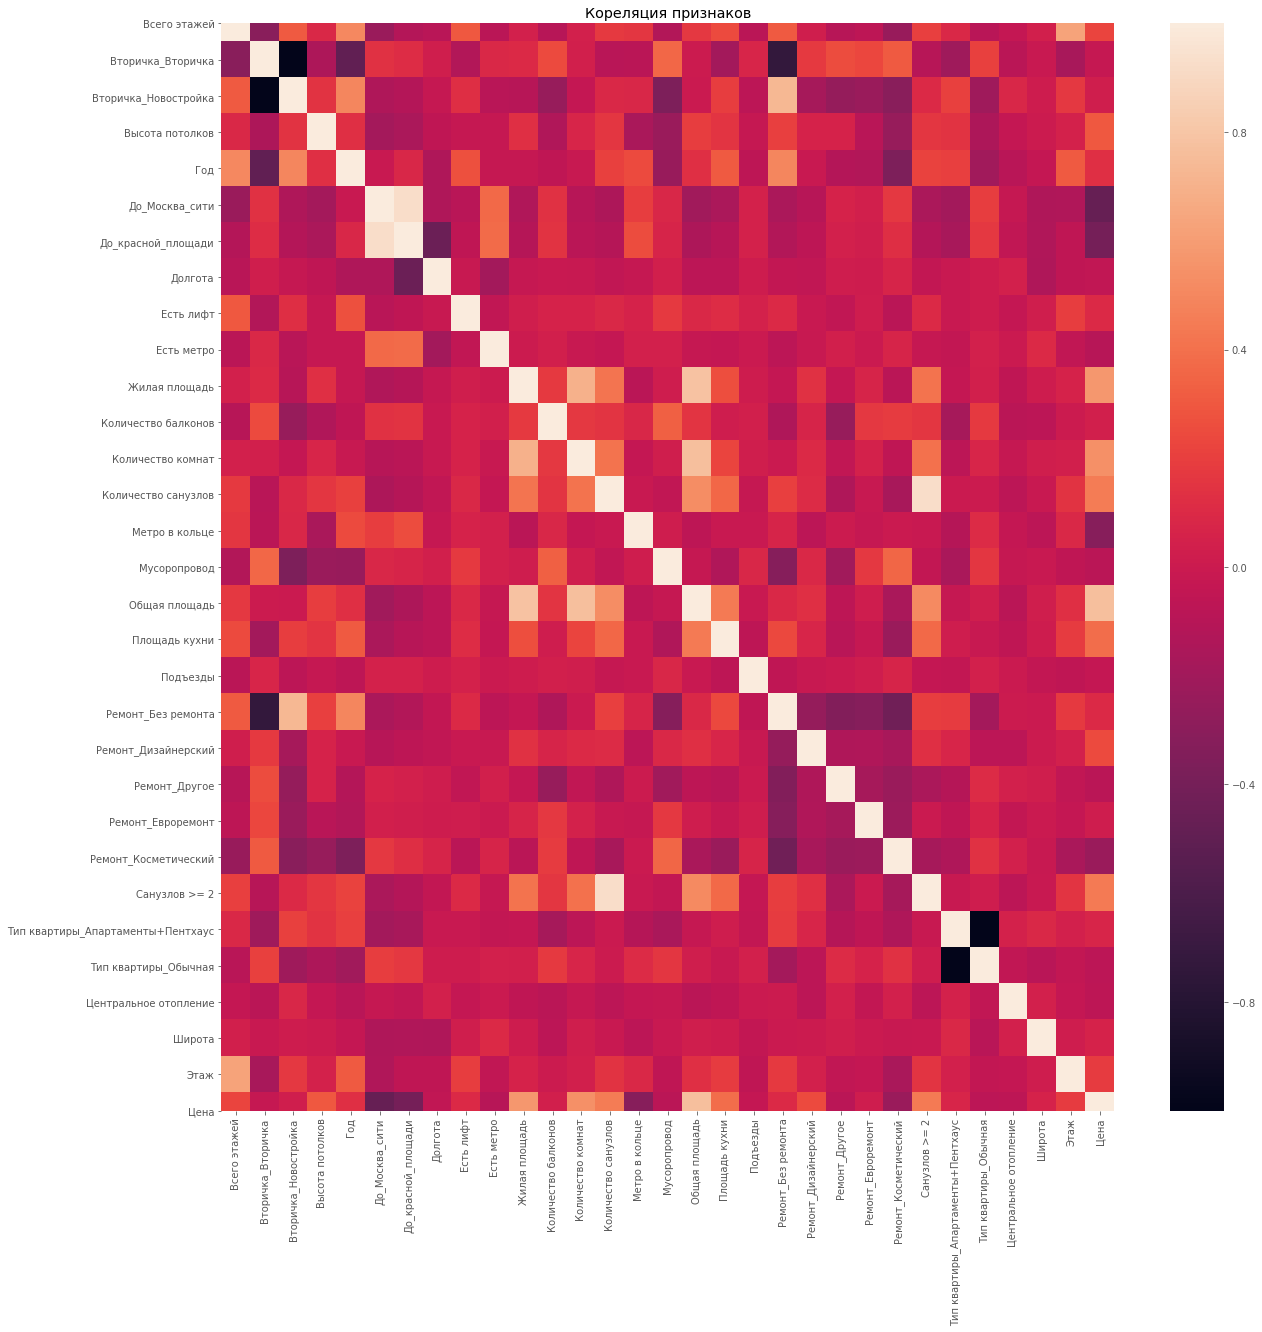

In [1075]:
plt.figure(figsize=(20,20))

sns.heatmap(pd.concat([df_train, df_test]).corr())

plt.title('Кореляция признаков')

plt.show()

<b>Корелируют с ценой:</b> общая площадь, количество комнат, до_москва_сити, до_красной_площади, количество санузлов.
    
<b>Корелируют друг с другом</b>, не считая созданных бинарных признаков: без ремонта/вторичка, расстояние до москва сити/до красной площади, количество комнат/площади, жилая площадь/общая площадь/площадь кухни.

## Обучение модели

Обучим модель сначала на всех признаках:

In [1082]:
from sklearn.preprocessing import RobustScaler

In [1083]:
X_train, y_train, X_test, y_test = np.array(df_train)[:, :-1], np.array(df_train)[:, -1], np.array(df_test)[:, :-1], np.array(df_test)[:, -1]

In [1084]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [672]:
from sklearn import linear_model
from sklearn import preprocessing

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

In [704]:
lr_pred[13], y_test[13]

(6160607.408092853, 6650000.0)

In [675]:
from sklearn import metrics

In [677]:
print('MAE train =', metrics.mean_absolute_error(y_train, lr.predict(X_train)))
print('R2 train =', metrics.r2_score(y_train, lr.predict(X_train)))
print('MAE test =', metrics.mean_absolute_error(y_test, lr.predict(X_test)))
print('R2 test =', metrics.r2_score(y_test, lr.predict(X_test)))

MAE train = 3256866.8946256945
R2 train = 0.7852033178956035
MAE test = 3365565.9151553153
R2 test = 0.7512623246363449


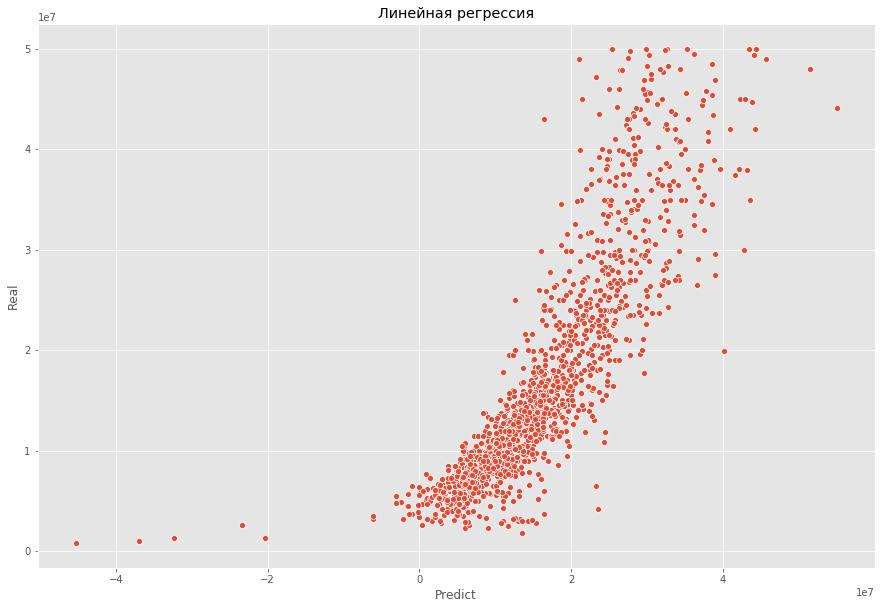

In [678]:
plt.figure(figsize=[15,10])

sns.scatterplot(lr_pred, y_test)

plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Линейная регрессия')

plt.show()

Посмотрим на распределение коэффициентов:

In [679]:
coeffs_arr = np.array(sorted(list(zip(df_train.columns[:-1], lr.coef_)), key=lambda x: x[1]))

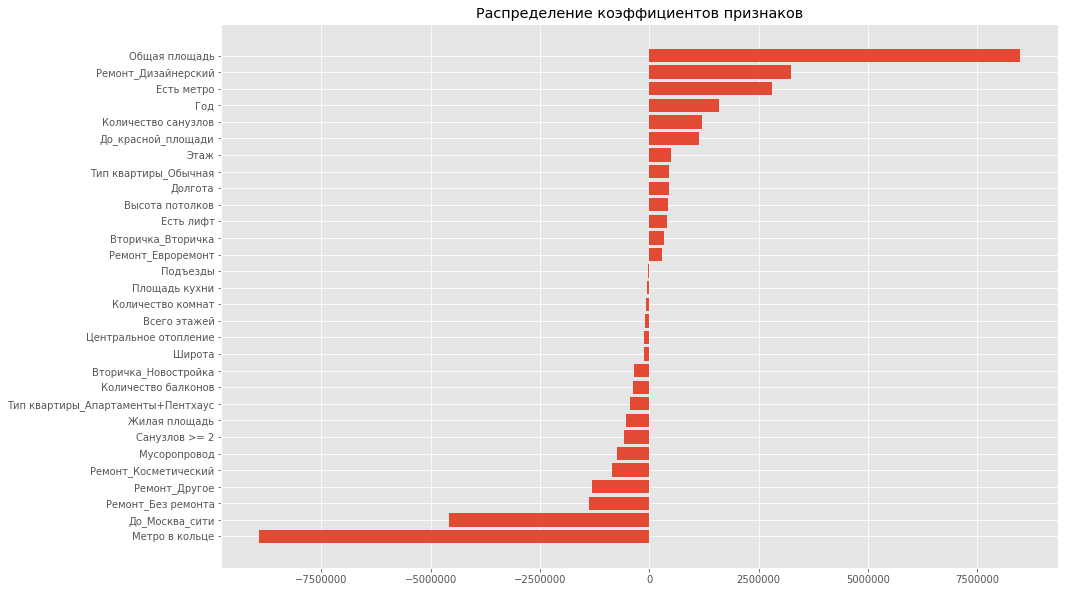

In [702]:
plt.figure(figsize=[15,10])

plt.barh(coeffs_arr[:, 0], coeffs_arr[:, 1].astype('float'))
plt.title('Распределение коэффициентов признаков')

plt.show()

Теперь попробуем дерево решений:

In [692]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=6, random_state=42)

dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

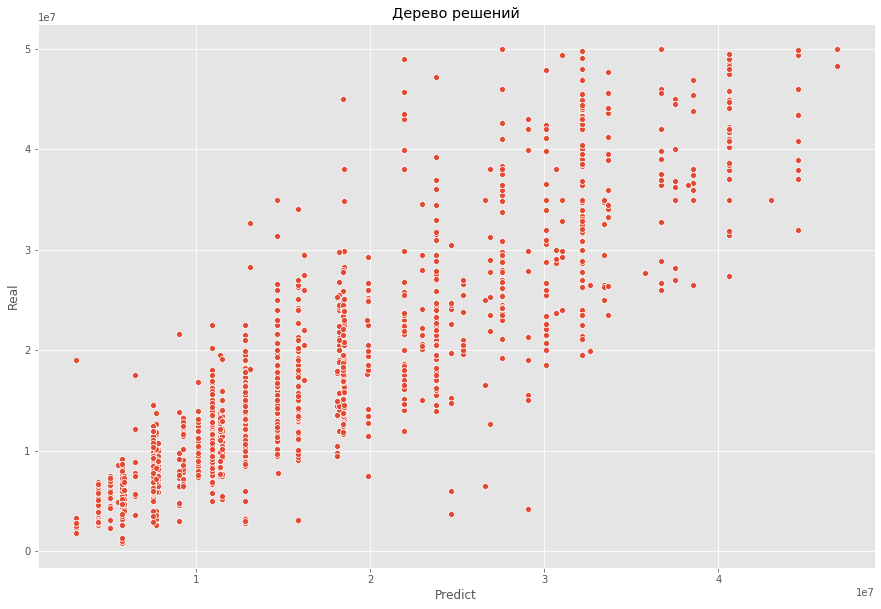

In [693]:
plt.figure(figsize=[15,10])

sns.scatterplot(dtr_pred, y_test)

plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Дерево решений')

plt.show()

Результат лучше, чем на линейной регрессии:

In [694]:
print('MAE train =', metrics.mean_absolute_error(y_train, dtr.predict(X_train)))
print('R2 train =', metrics.r2_score(y_train, dtr.predict(X_train)))
print('MAE test =', metrics.mean_absolute_error(y_test, dtr.predict(X_test)))
print('R2 test =', metrics.r2_score(y_test, dtr.predict(X_test)))

MAE train = 2554135.0366717987
R2 train = 0.8613650962583457
MAE test = 2981538.138071589
R2 test = 0.8036956185361075


Найдем лучшие параметры для дерева:

In [695]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [696]:
tree_params = {'max_depth': range(1, 11), 'max_features': range(1, 24)}
tree_grid = GridSearchCV(dtr, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 230 candidates, totalling 1150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 964 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1150 out of 1150 | elapsed:   19.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=6,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(1, 24)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=

In [697]:
tree_grid.best_params_

{'max_depth': 7, 'max_features': 22}

In [698]:
tree_grid.best_score_

0.8148507496370287

In [699]:
dtr_best = DecisionTreeRegressor(max_depth=7, max_features=22, random_state=42)
dtr_best.fit(X_train, y_train)
dtr_pred_best = dtr_best.predict(X_test)

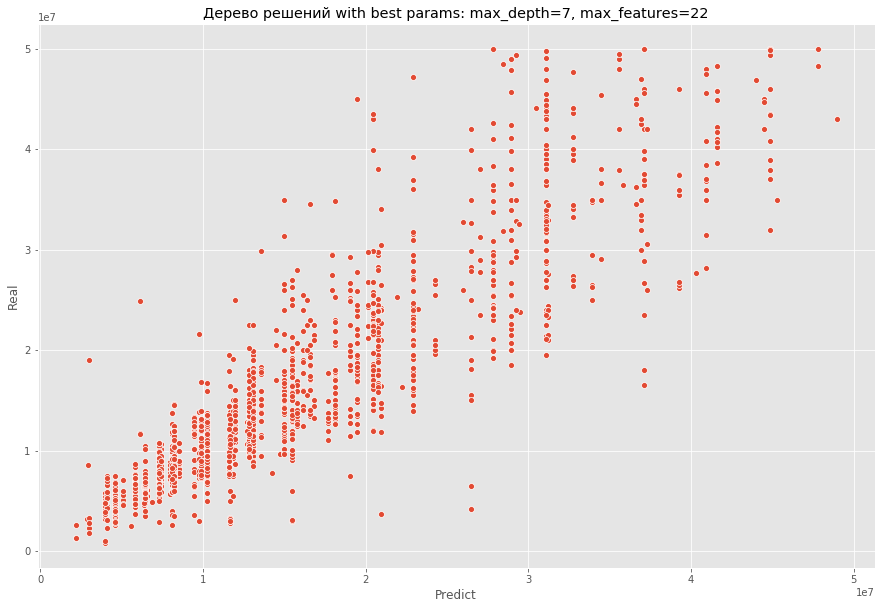

In [700]:
plt.figure(figsize=[15,10])

sns.scatterplot(dtr_pred_best, y_test)

plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Дерево решений with best params: max_depth={}, max_features={}'.format(tree_grid.best_params_['max_depth'], tree_grid.best_params_['max_features']))

plt.show()

Стало немного лучше:

In [701]:
print('MAE train =', metrics.mean_absolute_error(y_train, dtr_best.predict(X_train)))
print('R2 train =', metrics.r2_score(y_train, dtr_best.predict(X_train)))
print('MAE test =', metrics.mean_absolute_error(y_test, dtr_best.predict(X_test)))
print('R2 test =', metrics.r2_score(y_test, dtr_best.predict(X_test)))

MAE train = 2315044.1883543986
R2 train = 0.8794915710232127
MAE test = 2865840.8702623527
R2 test = 0.8134296175136984


Теперь случайный лес:

In [729]:
from sklearn.ensemble import RandomForestRegressor

In [746]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=7, min_samples_leaf=3, min_samples_split=3, random_state=42, n_jobs=-1)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

In [747]:
rfr_pred[35], y_test[35]

(29887227.110553622, 38355200.0)

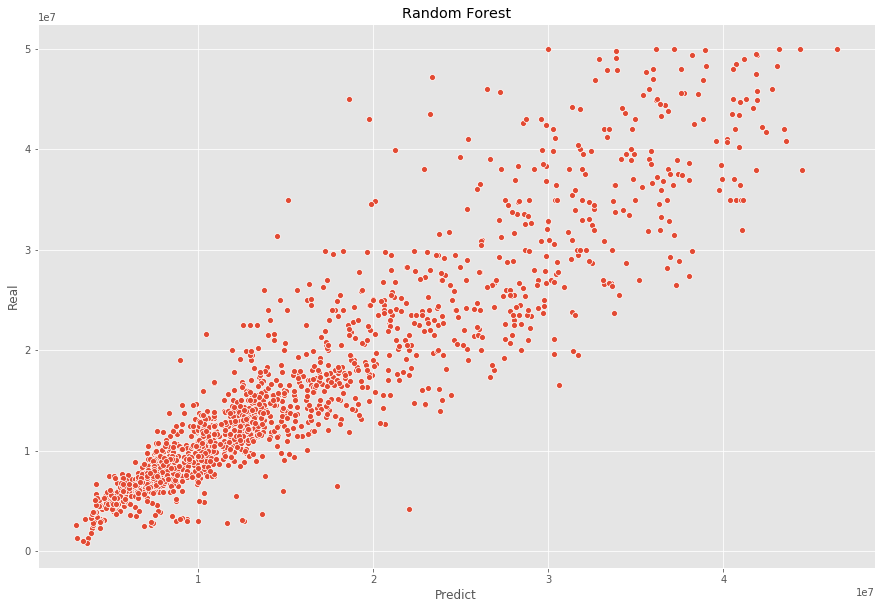

In [748]:
plt.figure(figsize=(15,10))
sns.scatterplot(rfr_pred, y_test)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Random Forest')
plt.show()

In [749]:
print('MAE train =', metrics.mean_absolute_error(y_train, rfr.predict(X_train)))
print('R2 train =', metrics.r2_score(y_train, rfr.predict(X_train)))
print('MAE test =', metrics.mean_absolute_error(y_test, rfr.predict(X_test)))
print('R2 test =', metrics.r2_score(y_test, rfr.predict(X_test)))

MAE train = 2009341.421104843
R2 train = 0.9154019310841599
MAE test = 2499451.8296012534
R2 test = 0.8591028851453012


In [727]:
rfr_imp = np.array(sorted(list(zip(df_train.columns[:-1], rfr.feature_importances_)), key=lambda x: x[1], reverse=False))

<BarContainer object of 30 artists>

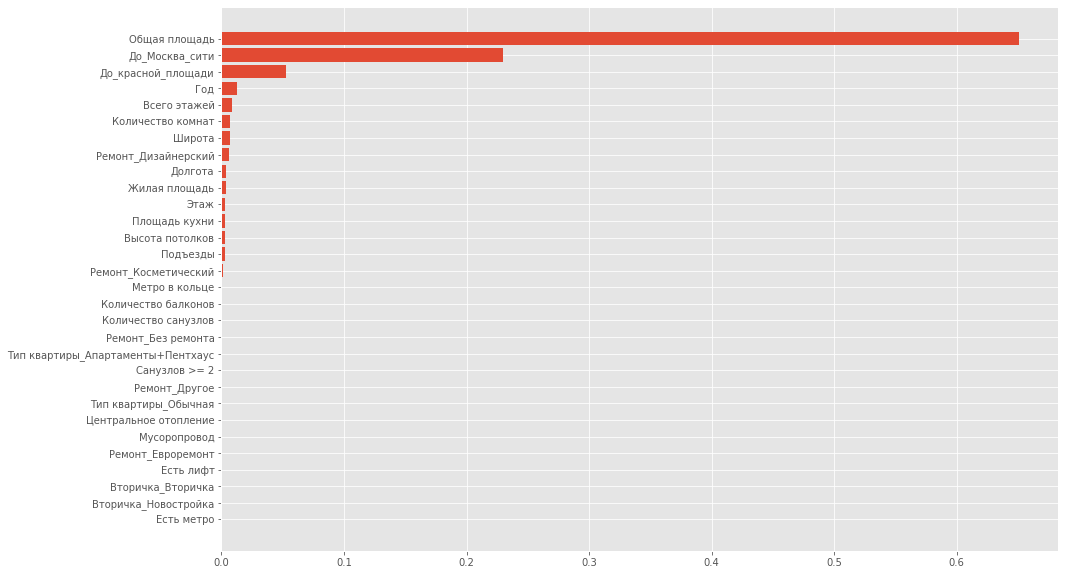

In [728]:
plt.figure(figsize=[15,10])
plt.barh(rfr_imp[:, 0], rfr_imp[:, 1].astype('float'))

Теперь бустинг:

In [797]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 4, 'max_features': 15, 'min_samples_split': 2, 'learning_rate': 0.08}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

In [798]:
clf_pred[0], y_test[0]

(14072983.430407986, 16748625.0)

Бустинг отработал с лучшими результатами среди всех моделей:

In [799]:
print('MAE train =', metrics.mean_absolute_error(y_train, clf.predict(X_train)))
print('R2 train =', metrics.r2_score(y_train, clf.predict(X_train)))
print('MAE test =', metrics.mean_absolute_error(y_test, clf.predict(X_test)))
print('R2 test =', metrics.r2_score(y_test, clf.predict(X_test)))

MAE train = 1104112.8707317042
R2 train = 0.9767224597511837
MAE test = 2058183.059206937
R2 test = 0.8980692495517476


Теперь подберем наилучшие гиперпараметры для бустинга с помощью GridSearchCV:

In [808]:
gbr_params = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': range(2, 6), 
              'max_features': range(5, 15), 'min_samples_split': range(2, 5), 
              'learning_rate': np.arange(0.04, 0.11, 0.01)}

gbr_grid = GridSearchCV(clf, gbr_params, cv=5, n_jobs=-1, verbose=True)
gbr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4800 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 75.6min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 100.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 112.4min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 135.2min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 157.8min
[Parallel(n_jobs=-1)]: Done 11242 tasks   

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.08,
                                                 loss='ls', max_depth=4,
                                                 max_features=15,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500,
                                                 n_iter_...
                             

In [810]:
gbr_grid.best_params_, gbr_grid.best_score_

({'learning_rate': 0.09000000000000001,
  'max_depth': 5,
  'max_features': 11,
  'min_samples_split': 2,
  'n_estimators': 500},
 0.9147698359989348)

In [1085]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 5, 'max_features': 11, 'min_samples_split': 2, 'learning_rate': 0.09}
clf = GradientBoostingRegressor(**params, random_state=42)

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

In [1086]:
print('MAE train =', metrics.mean_absolute_error(y_train, clf.predict(X_train)))
print('R2 train =', metrics.r2_score(y_train, clf.predict(X_train)))
print('MAE test =', metrics.mean_absolute_error(y_test, clf.predict(X_test)))
print('R2 test =', metrics.r2_score(y_test, clf.predict(X_test)))

MAE train = 702007.8476855352
R2 train = 0.9911405900384082
MAE test = 1957694.1818790706
R2 test = 0.9020591850902142


Оценим значимость признаков:

In [1087]:
clf_imp = np.array(sorted(list(zip(df_train.columns[:-1], clf.feature_importances_)), key=lambda x: x[1], reverse=False))

<BarContainer object of 30 artists>

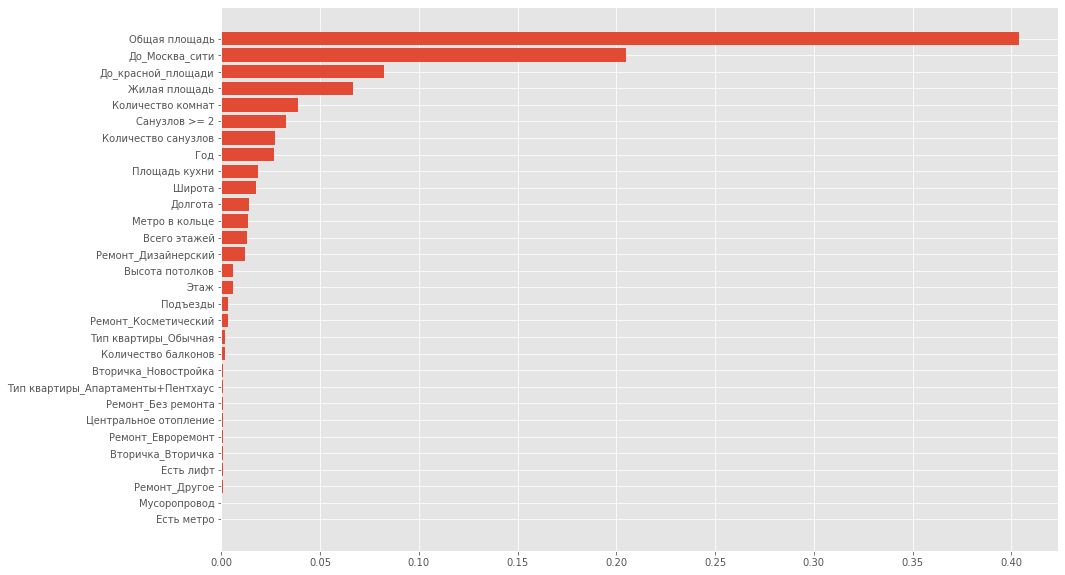

In [1088]:
plt.figure(figsize=[15,10])
plt.barh(clf_imp[:, 0], clf_imp[:, 1].astype('float'))

Наглядно оценим предикты и реальные значения:

In [1094]:
pd.DataFrame(np.c_[clf_pred.astype('int'), y_test], columns=['Predict price', 'Real price']).sample(50)

,Predict price,Real price
1396,12436876.0,14551500.0
1497,23038446.0,28000000.0
1238,9988101.0,11300000.0
503,9635646.0,8900000.0
832,10454992.0,9862400.0
1349,15175739.0,17700000.0
1740,7412910.0,7500000.0
289,12272535.0,18000000.0
1745,7046500.0,6270000.0
421,3236456.0,3400000.0


In [ ]:
import _pickle as Cpickle

In [ ]:
with open('predict.pkl', 'wb') as fid:
    Cpickle.dump(clf, fid)

In [ ]:
with open('predict.pkl', 'rb') as fid:
    clf_load = Cpickle.load(fid)

In [ ]:
test_cian = np.array([0, 8, 1, 0, 2.97, 1959, 9.486942998025995, 4.592379340744684, 37.681443, 1, 1, 37.0, 2, 8.0, 0, 0, 55.0, 0, 1, 6, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 55.777094, 3]).reshape(1,-1)
test_cian.shape

In [ ]:
test_cian

In [ ]:
clf_load.predict(test_cian)